# Generate Wind and Solar Renewable Generation Profiles for Llano Estacado (White Deer)
Address: 1950 Co Rd V, White Deer, TX 79097
Latitude: 35.46789100709006
Longitude: -101.2366719020712

## Wind Real-Time Generation


In [1]:
# Use virtual environment "h2_ws" to run the program
# conda activate h2_ws

In [1]:
# Set up libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import matplotlib.dates as mdates
from pathlib import Path
import os
import numpy as np
from datetime import datetime
from dateutil import parser
from scipy.integrate import simpson

# Check versions
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Pandas version: 2.2.3
NumPy version: 2.1.2


### Read in and Format Data

In [3]:
# Define the path to the input Excel file and the sheet name
file_path = Path(
    "weekly_wdwf_data/EnergyDetails_YTD.xlsx"
)
sheet_name = "Sheet1" # Previously "Data_Entity"

# Read the specified range from the Excel file
wind_data = pd.read_excel(
    file_path, sheet_name=sheet_name, usecols="A:Q", # skiprows=1,
      nrows=105409
)

In [4]:
# # Drop the first column of wind_data (assumed to be 'element')
# wind_data = wind_data.drop(wind_data.columns[0], axis=1)

In [5]:
# Ensure Date column is in datetime format (though it should already be)
wind_data.iloc[:, 1] = pd.to_datetime(wind_data.iloc[:, 1])

# Inspect and convert Time column to hh:mm:ss format if necessary
time_column = wind_data.iloc[:, 2]

# Replace '24:00' with '00:00' and add one day to the corresponding date
time_column = time_column.replace("24:00", "00:00")
wind_data.iloc[:, 1] = wind_data.iloc[:, 1] + pd.to_timedelta(
    (time_column == "00:00").astype(int), unit="D"
)

In [6]:
# Convert the time column to hh:mm:ss format if necessary
if not time_column.str.match(r"^\d{2}:\d{2}:\d{2}$").all():
    # Assuming the time column is in a different format, e.g., hh:mm or hh:mm:ss.sss
    # Clean and convert to hh:mm:ss format
    def clean_time_string(time_str):
        # Extract the time part using regex
        match = re.search(r"\d{2}:\d{2}(:\d{2})?", time_str)
        if match:
            return match.group(0)
        return "00:00:00"  # Default value if no match found

    wind_data.iloc[:, 2] = time_column.apply(
        lambda x: pd.to_datetime(clean_time_string(x)).strftime("%H:%M:%S")
    )

# Convert Time column to timedelta and add to Date to form a complete Datetime
wind_data["Datetime"] = wind_data.iloc[:, 1] + pd.to_timedelta(wind_data.iloc[:, 2])

# Set Datetime as the index of the DataFrame
wind_data.set_index("Datetime", inplace=True)

# Sort the DataFrame by the Datetime index
wind_data.sort_index(inplace=True)

# Rename columns to lowercase and replace spaces with underscores
wind_data.columns = wind_data.columns.str.lower().str.replace(" ", "_")

# Rename specific columns for clarity
wind_data.rename(
    columns={
        "real-time_billing_meter_quantity_mwh": "wind_real-time_generation_mw",
        "hourly_wind_forecast_mwh": "wind_forecast_mw",
        "real-time_lmp_$": "real-time_lmp_[$/mwh]",
        "day-ahead_lmp_$": "day-ahead_lmp_[$/mwh]",
        "5m-real-time_billing_meter_quantity_mwh":"5m-real-time_billing_meter_quantity_[mw]"
    },
    inplace=True
)

In [7]:
# Convert the 5M-real-time generation in column index 10 to the opposite of its existing value
wind_data.iloc[:, 10] = wind_data.iloc[:, 10] * -1

# # Convert generation data in column index 6 to the opposite of its existing value
# wind_data.iloc[:, 6] = wind_data.iloc[:, 6] * -1

### Define Target Dates for Analysis

In [8]:
# Target dates for analysis
start_date = "2024-10-01"
start_date_long_format = pd.to_datetime(start_date).strftime("%B %d, %Y")
end_date = "2024-10-08"
end_date_long_format = pd.to_datetime(end_date).strftime("%B %d, %Y")
target_day = "2024-10-02"
target_day_long_format = pd.to_datetime(target_day).strftime("%B %d, %Y")

In [9]:
# Plot specific period of wind generation data
filtered_wind_data = wind_data.loc[start_date:end_date]

# Extract the 'real-time lmp price' column
lmp_prices = filtered_wind_data["real-time_lmp_[$/mwh]"]

# Calculate the average
average_lmp_price = lmp_prices.mean()
max_lmp_price = lmp_prices.max()
min_lmp_price = lmp_prices.min()

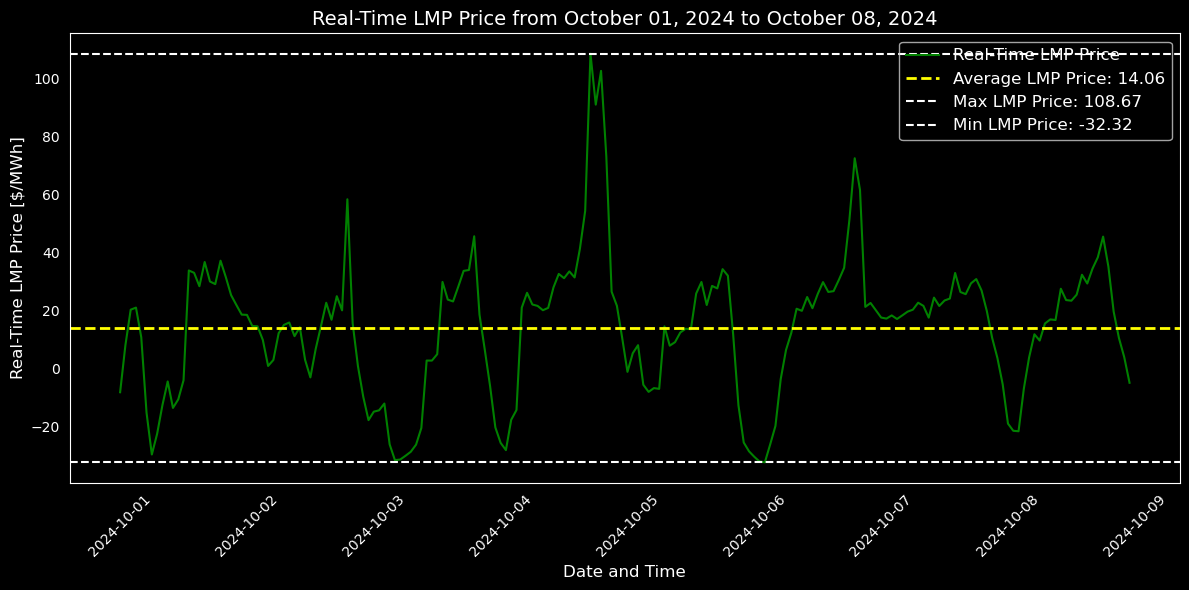

In [10]:
# Plot only real-time LMP price for the filtered period
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=filtered_wind_data,
    x=filtered_wind_data.index,
    y="real-time_lmp_[$/mwh]",
    color="green",
    label="Real-Time LMP Price"
)
plt.axhline(
    average_lmp_price,
    color="yellow",
    linestyle="--",
    linewidth=2,
    label=f"Average LMP Price: {average_lmp_price:.2f}",
)
plt.axhline(
    max_lmp_price,
    color="white",
    linestyle="--",
    linewidth=1.5,
    label=f"Max LMP Price: {max_lmp_price:.2f}",
)
plt.axhline(
    min_lmp_price,
    color="white",
    linestyle="--",
    linewidth=1.5,
    label=f"Min LMP Price: {min_lmp_price:.2f}",
)
plt.title(
    f"Real-Time LMP Price from {start_date_long_format} to {end_date_long_format}", fontsize=14, color="white"
)
plt.xlabel("Date and Time", fontsize=12, color="white")
plt.ylabel("Real-Time LMP Price [$/MWh]", fontsize=12, color="white")
plt.xticks(rotation=45, fontsize=10, color="white")
plt.yticks(fontsize=10, color="white")
legend = plt.legend(fontsize=12)
legend.get_frame().set_facecolor("none")
for text in legend.get_texts():
    text.set_color("white")

ax = plt.gca()
ax.spines["bottom"].set_color("white")
ax.spines["top"].set_color("white")
ax.spines["right"].set_color("white")
ax.spines["left"].set_color("white")
ax.set_facecolor("black")
plt.gcf().patch.set_facecolor("black")
plt.tight_layout()
plt.show()


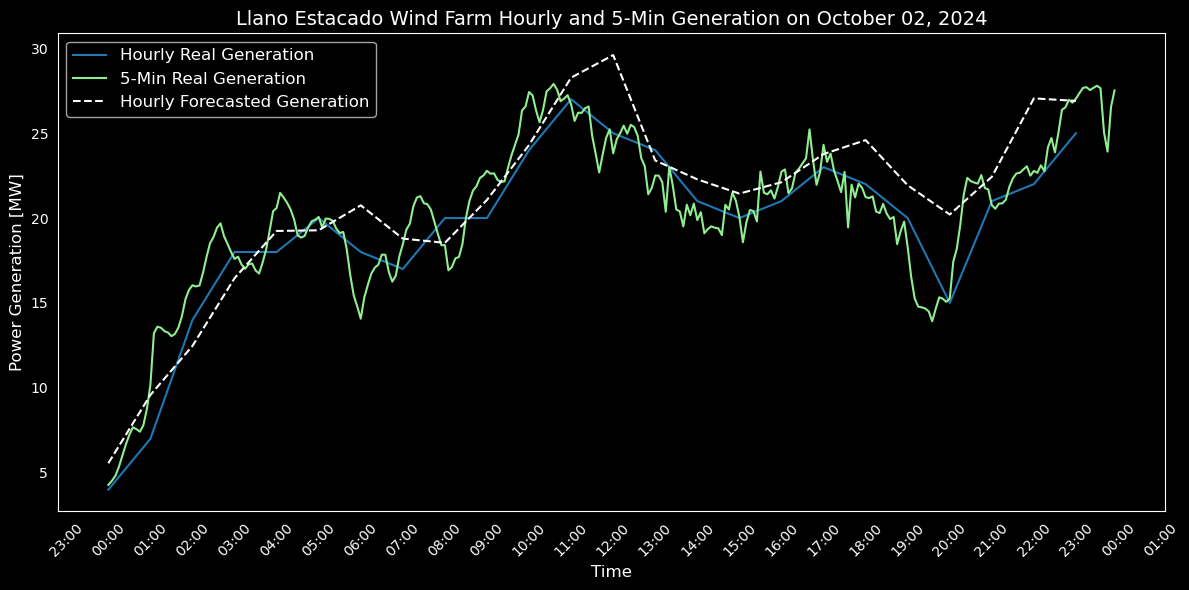

In [11]:
# Filter data for 1-Day
# # For plotting purposes only, we will use the following date:
day_data = wind_data.loc[target_day]

# Plot hourly power generation and 5-min generation for October 2, 2019
plt.figure(figsize=(12, 6))

# Plot hourly power generation
sns.lineplot(data=day_data, x=day_data.index, y=day_data["wind_real-time_generation_mw"], label="Hourly Real Generation")

# Plot 5-min generation
sns.lineplot(data=day_data, x=day_data.index, y=day_data["5m-real-time_billing_meter_quantity_[mw]"], label="5-Min Real Generation", color="lightgreen")

# Plot forecasted generation
sns.lineplot(
    data=day_data,
    x=day_data.index,
    y=day_data["wind_forecast_mw"],
    label="Hourly Forecasted Generation",
    color="white",
    linestyle="--",
)

plt.title(
    f"Llano Estacado Wind Farm Hourly and 5-Min Generation on {target_day_long_format}",
    fontsize=14,
    color="white",
)
plt.xlabel("Time", fontsize=12, color="white")
plt.ylabel("Power Generation [MW]", fontsize=12, color="white")
plt.xticks(rotation=45, fontsize=10, color="white")
plt.yticks(fontsize=10, color="white")

# Set major ticks to hourly intervals
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

# Set the axes lines to white
ax = plt.gca()
ax.spines["bottom"].set_color("white")
ax.spines["top"].set_color("white")
ax.spines["right"].set_color("white")
ax.spines["left"].set_color("white")

# Set the background color of the plot to black
plt.gcf().patch.set_facecolor("black")
ax.set_facecolor("black")

# Add legend
legend = plt.legend(fontsize=12)
legend.get_frame().set_facecolor("none")  # Make the legend box background clear
for text in legend.get_texts():
    text.set_color("white")

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## Solar PV Simulated Generation
RenewablesNinja
20 MW, 0.1 Loss, No Tracking

### Read in and Format Data

In [12]:
# Load simulated solar PV data from RenewablesNinja at 20 MW, 0.1 loss, no tracking

# Load the data for 2019
solar_file_path_2019 = Path(
    "renewables_ninja_solar_data/ninja_pv_2019_20mw_0.1loss_notrack.csv"
)

solar_data_2019 = pd.read_csv(
    solar_file_path_2019, usecols=[0, 1, 2], skiprows=3, nrows=8760, header=0
)

print(solar_data_2019.columns)


# Load the data for 2020
solar_file_path_2020 = Path(
    "renewables_ninja_solar_data/ninja_pv_2020_20mw_0.1loss_notrack.csv"
)
solar_data_2020 = pd.read_csv(
    solar_file_path_2020, usecols=[0, 1, 2], skiprows=3, nrows=8784, header=0
) # Adjusted for leap year
print(solar_data_2020.columns)

#Load the data for 2021
solar_file_path_2021 = Path(
    "renewables_ninja_solar_data/ninja_pv_2021_20mw_0.1loss_notrack.csv"
)
solar_data_2021 = pd.read_csv(
    solar_file_path_2021, usecols=[0, 1, 2], skiprows=3, nrows=8760, header=0
)
print(solar_data_2021.columns)

# Load the data for 2022
solar_file_path_2022 = Path(
    "renewables_ninja_solar_data/ninja_pv_2022_20mw_0.1loss_notrack.csv"
)
solar_data_2022 = pd.read_csv(
    solar_file_path_2022, usecols=[0, 1, 2], skiprows=3, nrows=8760, header=0
)
print(solar_data_2022.columns)

# Load the data for 2023
solar_file_path_2023 = Path(
    "renewables_ninja_solar_data/ninja_pv_2023_20mw_0.1loss_notrack.csv"
)
solar_data_2023 = pd.read_csv(
    solar_file_path_2023, usecols=[0, 1, 2], skiprows=3, nrows=8760, header=0
)
print(solar_data_2023.columns)

# Load the data for 2024
solar_file_path_2024 = Path(
    "renewables_ninja_solar_data/ninja_pv_2024_20mw_0.1loss_notrack.csv"
)
solar_data_2024 = pd.read_csv(
    solar_file_path_2024, usecols=[0, 1, 2], skiprows=3, nrows=8784, header=0
) # Adjusted for leap year
print(solar_data_2024.columns)


Index(['time', 'local_time', 'electricity'], dtype='object')
Index(['time', 'local_time', 'electricity'], dtype='object')
Index(['time', 'local_time', 'electricity'], dtype='object')
Index(['time', 'local_time', 'electricity'], dtype='object')
Index(['time', 'local_time', 'electricity'], dtype='object')
Index(['time', 'local_time', 'electricity'], dtype='object')


In [13]:
# Combine all solar data into a single DataFrame
solar_data = pd.concat([solar_data_2019, solar_data_2020, solar_data_2021, solar_data_2022, solar_data_2023, solar_data_2024], axis=0, ignore_index=True)
solar_data.head()

,time,local_time,electricity
0,3/27/1900 0:00,12/31/2018 18:00,0.0
1,1/1/2019 1:00,12/31/2018 19:00,0.0
2,1/1/2019 2:00,12/31/2018 20:00,0.0
3,1/1/2019 3:00,12/31/2018 21:00,0.0
4,1/1/2019 4:00,12/31/2018 22:00,0.0


In [14]:
solar_data.tail()

,time,local_time,electricity
52603,2024-12-31 19:00,2024-12-31 13:00,14961.656
52604,2024-12-31 20:00,2024-12-31 14:00,11981.417
52605,2024-12-31 21:00,2024-12-31 15:00,7319.999
52606,2024-12-31 22:00,2024-12-31 16:00,5996.645
52607,2024-12-31 23:00,2024-12-31 17:00,664.126


In [15]:
# Convert the "local_time" column to datetime, handling multiple formats and errors
def robust_parse_datetime(val):
    try:
        return parser.parse(val, fuzzy=True)
    except Exception:
        return pd.NaT

solar_data["local_time"] = solar_data["local_time"].apply(robust_parse_datetime)

# Set the local time column as the index using DatetimeIndex, drop rows with NaT index
solar_data.set_index(pd.DatetimeIndex(solar_data["local_time"]), inplace=True)
solar_data.index.name = "Datetime"
solar_data = solar_data[~solar_data.index.isna()]

# Rename columns to match data, remove spaces, and make all lowercase
solar_data.columns = [
    "solar_date_time",
    "solar_local_time_iso_8601",
    "solar_generation_kw",
]

In [16]:
# Convert solar_generation_kw from kW to MW and rename the column to solar_generation_mw
solar_data["solar_generation_mw"] = solar_data["solar_generation_kw"] / 1000
# Drop the original solar_generation_kw column
solar_data.drop(columns=["solar_generation_kw"], inplace=True)

In [17]:
# Filter data for the specified date range
filtered_solar_data = solar_data.loc[start_date:end_date]

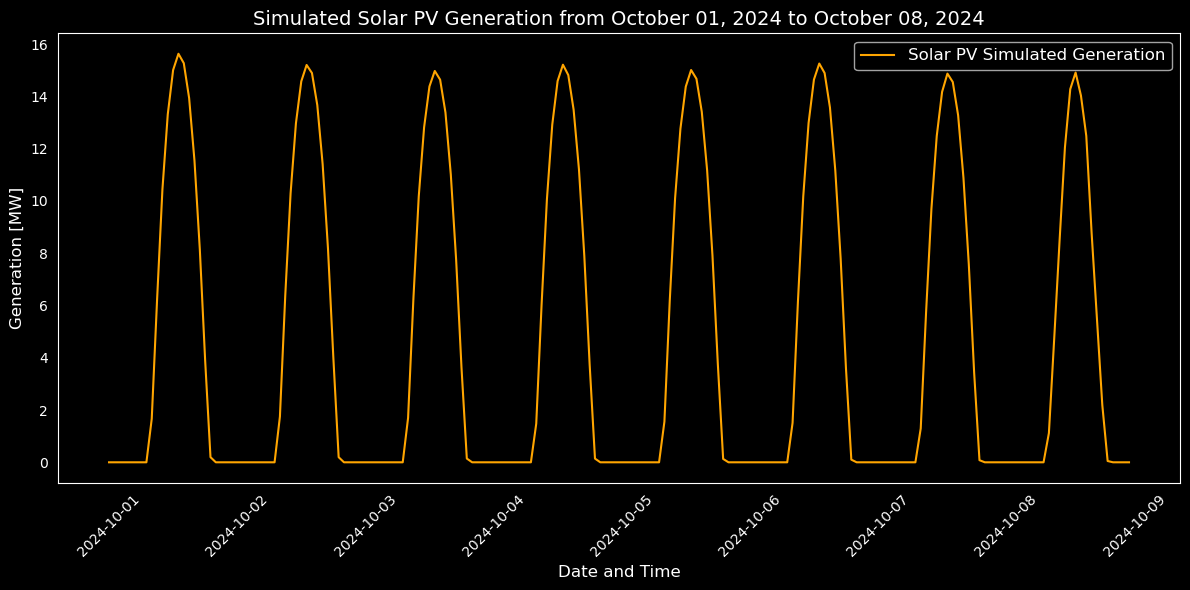

In [18]:
# Plot local time and generation
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=filtered_solar_data,
    x=filtered_solar_data.index,
    y=filtered_solar_data.iloc[:, 2],
    color="orange",
    label="Solar PV Simulated Generation",
)
plt.title(
    f"Simulated Solar PV Generation from {start_date_long_format} to {end_date_long_format}",
    fontsize=14,
    color="white",
)
plt.xlabel("Date and Time", fontsize=12, color="white")
plt.ylabel("Generation [MW]", fontsize=12, color="white")
plt.xticks(rotation=45, fontsize=10, color="white")
plt.yticks(fontsize=10, color="white")

# Set major ticks to daily intervals
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

# Set the axes lines to white
ax = plt.gca()
ax.spines["bottom"].set_color("white")
ax.spines["top"].set_color("white")
ax.spines["right"].set_color("white")
ax.spines["left"].set_color("white")

# Set the background color of the plot to black
plt.gcf().patch.set_facecolor("black")
ax.set_facecolor("black")

# Customize legend font color to white and make the legend box background clear
legend = plt.legend(fontsize=12)
legend.get_frame().set_facecolor("none")  # Make the legend box background clear
for text in legend.get_texts():
    text.set_color("white")

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## Merge Data Sets

In [19]:
# Merge the filtered wind and solar data on their datetime index using an inner join
merged_data = pd.merge(
    wind_data, solar_data, left_index=True, right_index=True, how="inner"
    # how="left"  # Uncomment this line if you want to keep all wind data even if there's no solar data
)

# Reset the index to include the datetime index as a column
merged_data.reset_index(inplace=True)

# Rename the 'index' column to 'datetime' for clarity
merged_data.rename(columns={"Datetime": "datetime_index"}, inplace=True)

# Set the 'datetime' column as the index
merged_data.set_index("datetime_index", inplace=True)

# Add a column for total generation in MW as the sum of wind and solar generation
merged_data["total_generation_mw"] = (
    merged_data["wind_real-time_generation_mw"] + merged_data["solar_generation_mw"]
)

merged_data.head()

,element,flowday_(central),interval,settlement_point,day-ahead_cleared_energy_quantity_mw,day-ahead_asset_energy_$,wind_real-time_generation_mw,real-time_lmp_[$/mwh],5m-day-ahead_cleared_energy_quantity_mw,5m-day-ahead_asset_energy_$,...,wind_forecast_mw,5m-generation_from_telemetry_$,5m-real-time_lmp_$,day-ahead_lmp_[$/mwh],5m-real-time_asset_energy_$,real-time_asset_energy_$,solar_date_time,solar_local_time_iso_8601,solar_generation_mw,total_generation_mw
datetime_index,,,,,,,,,,,,,,,,,,,,,
2024-09-15 01:00:00,"Llano Estacado Wind, LLC (White Deer)",2024-09-15,01:00:00,SPS.TNSK.LLANOWIND1UNIT,-16.0,0.8112,4.9999,-0.483792,-16.0,0.0676,...,14.16,5.518050,-0.4851,-0.0507,-0.425999,-4.807754,2024-09-15 06:00,2024-09-15 01:00:00,0.0,4.9999
2024-09-15 02:00:00,"Llano Estacado Wind, LLC (White Deer)",2024-09-15,02:00:00,SPS.TNSK.LLANOWIND1UNIT,0.0,0.0000,8.0001,-1.788283,0.0,0.0000,...,6.35,11.598354,0.0814,1.0990,-0.074535,12.985418,2024-09-15 07:00,2024-09-15 02:00:00,0.0,8.0001
2024-09-15 03:00:00,"Llano Estacado Wind, LLC (White Deer)",2024-09-15,03:00:00,SPS.TNSK.LLANOWIND1UNIT,0.0,0.0000,10.0000,-4.215808,0.0,0.0000,...,12.26,9.780687,-6.7744,0.4492,5.242257,40.196088,2024-09-15 08:00,2024-09-15 03:00:00,0.0,10.0000
2024-09-15 04:00:00,"Llano Estacado Wind, LLC (White Deer)",2024-09-15,04:00:00,SPS.TNSK.LLANOWIND1UNIT,0.0,0.0000,8.9999,-7.873975,0.0,0.0000,...,9.69,10.680147,-4.5333,0.7545,3.856705,70.907315,2024-09-15 09:00,2024-09-15 04:00:00,0.0,8.9999
2024-09-15 05:00:00,"Llano Estacado Wind, LLC (White Deer)",2024-09-15,05:00:00,SPS.TNSK.LLANOWIND1UNIT,0.0,0.0000,10.9999,1.078050,0.0,0.0000,...,10.74,12.136934,4.4399,1.5746,-4.495029,-14.268928,2024-09-15 10:00,2024-09-15 05:00:00,0.0,10.9999


### Overview of Merged Data

In [ ]:
# Analyze merged data
# Calculate daily sums for wind, solar, and combined generation
daily_wind = merged_data["wind_real-time_generation_mw"].resample("D").sum()
daily_solar = merged_data["solar_generation_mw"].resample("D").sum()
daily_combined = merged_data["total_generation_mw"].resample("D").sum()

weekly_wind = merged_data["wind_real-time_generation_mw"].resample("W").sum()
weekly_solar = merged_data["solar_generation_mw"].resample("W").sum()
weekly_combined = merged_data["total_generation_mw"].resample("W").sum()

how_many_values_to_display = 5

In [ ]:
# Find top days
top_daily_wind = daily_wind.sort_values(ascending=False).head(how_many_values_to_display)
top_daily_solar = daily_solar.sort_values(ascending=False).head(how_many_values_to_display)
top_daily_combined = daily_combined.sort_values(ascending=False).head(how_many_values_to_display)

# Find top weeks
top_weekly_wind = weekly_wind.sort_values(ascending=False).head(how_many_values_to_display)
top_weekly_solar = weekly_solar.sort_values(ascending=False).head(how_many_values_to_display)
top_weekly_combined = weekly_combined.sort_values(ascending=False).head(how_many_values_to_display)

# Print the top days for each category
print(f"Top {how_many_values_to_display} days with most wind generation:")
print(top_daily_wind)
print(f"Top {how_many_values_to_display} days with most solar generation:")
print(top_daily_solar)
print(f"Top {how_many_values_to_display} days with most combined generation:")
print(top_daily_combined)

# Print the top weeks for each category
print(f"Top {how_many_values_to_display} weeks with most wind generation:")
print(top_weekly_wind)
print(f"Top {how_many_values_to_display} weeks with most solar generation:")
print(top_weekly_solar)
print(f"Top {how_many_values_to_display} weeks with most combined generation:")
print(top_weekly_combined)

NameError: name 'merged_data' is not defined

In [ ]:
# Find bottom days for each category
bottom_daily_wind = daily_wind.sort_values(ascending=True).head(how_many_values_to_display)
bottom_daily_solar = daily_solar.sort_values(ascending=True).head(how_many_values_to_display)
bottom_daily_combined = daily_combined.sort_values(ascending=True).head(how_many_values_to_display)

# Find bottom weeks for each category
bottom_weekly_wind = weekly_wind.sort_values(ascending=True).head(how_many_values_to_display)
bottom_weekly_solar = weekly_solar.sort_values(ascending=True).head(how_many_values_to_display)
bottom_weekly_combined = weekly_combined.sort_values(ascending=True).head(how_many_values_to_display)

# Print the bottom days for each category
print(f"Bottom {how_many_values_to_display} days with least wind generation:")
print(bottom_daily_wind)
print(f"Bottom {how_many_values_to_display} days with least solar generation:")
print(bottom_daily_solar)
print(f"Bottom {how_many_values_to_display} days with least combined generation:")
print(bottom_daily_combined)

# Print the bottom weeks for each category
print(f"Bottom {how_many_values_to_display} weeks with least wind generation:")
print(bottom_weekly_wind)
print(f"Bottom {how_many_values_to_display} weeks with least solar generation:")
print(bottom_weekly_solar)
print(f"Bottom {how_many_values_to_display} weeks with least combined generation:")
print(bottom_weekly_combined)


Top 10 days with least wind generation:
datetime_index
2024-09-23    21.0003
2024-09-25     9.0001
2024-09-27    44.0007
2024-09-28    47.0000
2024-09-29    12.0764
2024-10-22     5.0001
2024-11-10     3.9999
2024-11-21    48.9999
2024-11-28    44.4110
2024-12-31    53.9997
Name: wind_real-time_generation_mw, dtype: float64

Top 10 days with least solar generation:
datetime_index
2024-09-21    36.181532
2024-09-22    46.593018
2024-10-18    58.196786
2024-11-02    13.934942
2024-11-08    51.881782
2024-11-18    59.733284
2024-12-13    44.195553
2024-12-23    55.261982
2024-12-24    48.664821
2024-12-25    35.212350
Name: solar_generation_mw, dtype: float64

Top 10 days with least total generation:
datetime_index
2024-09-23    138.835104
2024-09-25    124.960351
2024-09-27    157.215210
2024-09-29    126.669707
2024-10-22    116.123983
2024-11-10    115.939387
2024-11-21    160.591081
2024-11-28    153.822847
2024-12-24    118.664821
2024-12-31    154.134845
Name: total_generation_mw, 

In [22]:
# Calculate the average of total_generation_mw for the filtered period
average_total_generation = merged_data["total_generation_mw"].mean()
print(f"Average total generation (MW): {average_total_generation:.2f}")

# Find all timestamps where total generation is within ±5% of the average
tolerance = 0.05 * average_total_generation
near_average = merged_data[
    (merged_data["total_generation_mw"] >= average_total_generation - tolerance) &
    (merged_data["total_generation_mw"] <= average_total_generation + tolerance)
]

print("Timestamps with total generation near the average:")
print(near_average.index)

Average total generation (MW): 14.91
Timestamps with total generation near the average:
DatetimeIndex(['2024-09-16 02:00:00', '2024-09-16 12:00:00',
               '2024-09-16 19:00:00', '2024-09-17 22:00:00',
               '2024-09-19 13:00:00', '2024-09-19 14:00:00',
               '2024-09-20 07:00:00', '2024-09-21 12:00:00',
               '2024-09-21 13:00:00', '2024-09-22 18:00:00',
               ...
               '2024-12-21 10:00:00', '2024-12-21 11:00:00',
               '2024-12-21 13:00:00', '2024-12-25 19:00:00',
               '2024-12-28 10:00:00', '2024-12-28 14:00:00',
               '2024-12-28 23:00:00', '2024-12-29 13:00:00',
               '2024-12-31 08:00:00', '2024-12-31 13:00:00'],
              dtype='datetime64[ns]', name='datetime_index', length=156, freq=None)


### Plot Hourly Renewable Generation (Real Wind + Simulated Solar PV)

In [23]:
# Filter the merged data for the specified date range
filtered_merged_data = merged_data.loc[start_date:end_date]

# Copy the merged_data with only desired columns, including the datetime index
desired_columns = [
    "wind_real-time_generation_mw",
    "wind_forecast_mw",
    "solar_generation_mw",
    "real-time_lmp_[$/mwh]",
    "day-ahead_lmp_[$/mwh]",
    "5m-real-time_billing_meter_quantity_[mw]",
    "total_generation_mw",

]
filtered_merged_data = filtered_merged_data[
    desired_columns
].copy()  # Create a copy to avoid SettingWithCopyWarning

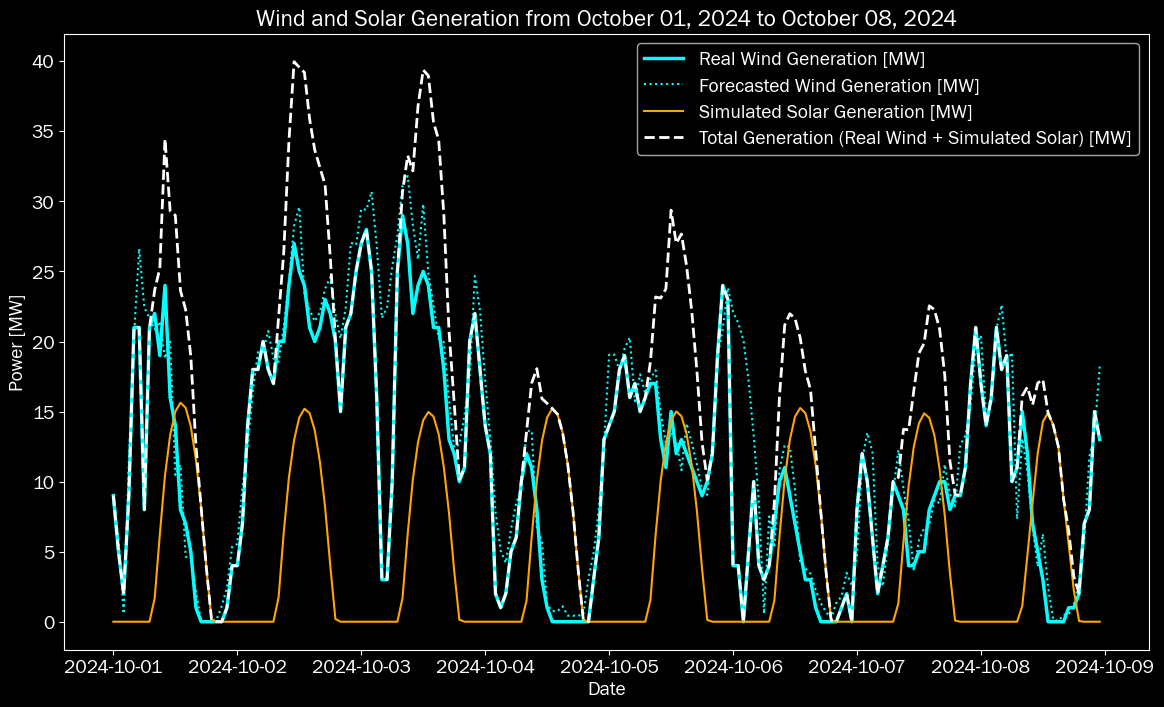

In [24]:
# Set the font to Franklin Gothic and increase font size
plt.rcParams["font.family"] = "Franklin Gothic Book"
plt.rcParams["font.size"] = 14

# Set the background color to black
plt.rcParams["axes.facecolor"] = "black"
plt.rcParams["figure.facecolor"] = "black"
plt.rcParams["savefig.facecolor"] = "black"

# Plot filtered_merged_data with all columns
plt.figure(figsize=(14, 8))

# Plot real-time billing meter quantity
plt.plot(
    filtered_merged_data.index,
    filtered_merged_data["wind_real-time_generation_mw"],
    label="Real Wind Generation [MW]",
    linestyle="-",
    color="cyan",
    linewidth=2.5,
)

# Plot hourly wind forecast
plt.plot(
    filtered_merged_data.index,
    filtered_merged_data["wind_forecast_mw"],
    label="Forecasted Wind Generation [MW]",
    linestyle=":",
    color="cyan",
    linewidth=1.5,
)

# Plot solar generation
plt.plot(
    filtered_merged_data.index,
    filtered_merged_data["solar_generation_mw"],
    label="Simulated Solar Generation [MW]",
    linestyle="-",
    color="orange",
)

# Plot total generation
plt.plot(
    filtered_merged_data.index,
    filtered_merged_data["total_generation_mw"],
    label="Total Generation (Real Wind + Simulated Solar) [MW]",
    linestyle="--",
    color="white",
    linewidth=2,
)

# Adding title and labels
plt.title(f"Wind and Solar Generation from {start_date_long_format} to {end_date_long_format}", color="white")
plt.xlabel("Date", color="white")
plt.ylabel("Power [MW]", color="white")

# Change the color of the tick labels and tick marks
plt.tick_params(colors="white", which="both")  # both major and minor ticks are affected

# Change the color of the axes
ax = plt.gca()  # get current axes
ax.spines["bottom"].set_color("white")
ax.spines["top"].set_color("white")
ax.spines["left"].set_color("white")
ax.spines["right"].set_color("white")

# Change the color of the legend text
legend = plt.legend()
for text in legend.get_texts():
    text.set_color("white")

# Display the plot
plt.show()

### Merge Data Sets for 1-Day

In [25]:
# Filter merged_data for the target day
filtered_merged_data = merged_data.loc[target_day]

# Copy the merged_data with only desired columns, including the datetime index
desired_columns = [
    "wind_real-time_generation_mw",
    "wind_forecast_mw",
    "solar_generation_mw",
    "real-time_lmp_[$/mwh]",
    "day-ahead_lmp_[$/mwh]",
    "5m-real-time_billing_meter_quantity_[mw]",
    "total_generation_mw",
]

filtered_merged_data = filtered_merged_data[
    desired_columns
].copy()  # Create a copy to avoid SettingWithCopyWarning

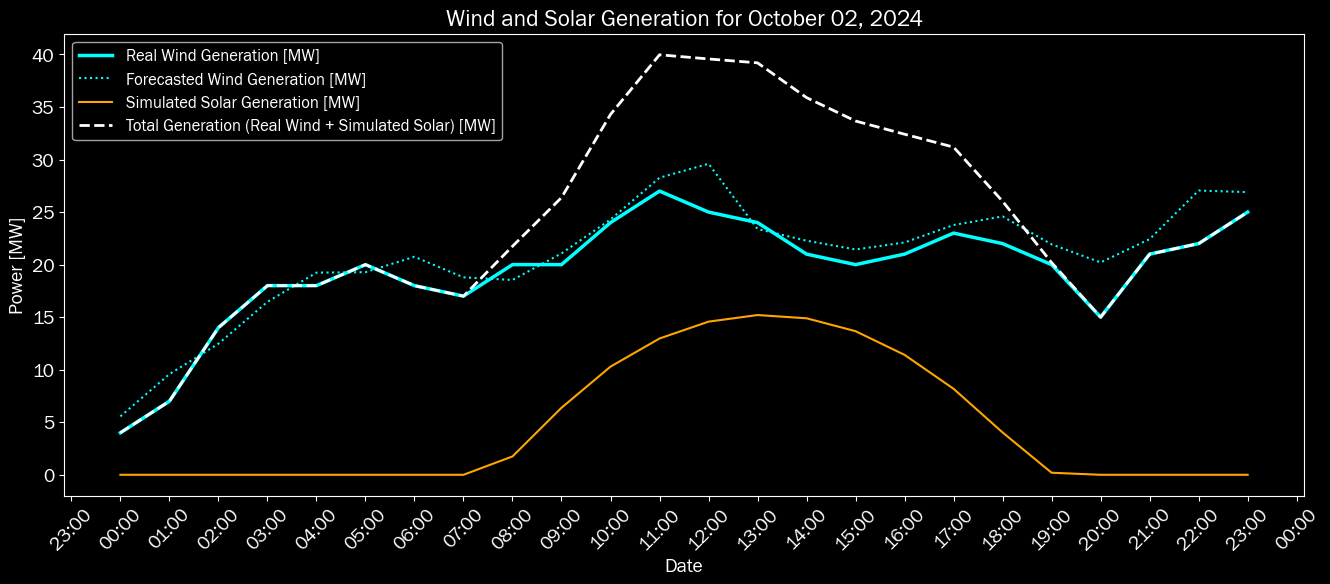

In [26]:
# Set the font to Franklin Gothic and increase font size
plt.rcParams["font.family"] = "Franklin Gothic Book"
plt.rcParams["font.size"] = 14

# Set the background color to black
plt.rcParams["axes.facecolor"] = "black"
plt.rcParams["figure.facecolor"] = "black"
plt.rcParams["savefig.facecolor"] = "black"

# Make the figure wider
plt.figure(figsize=(16, 6))  # Adjust the width to 16 for a wider plot

# Plot real-time billing meter quantity
plt.plot(
    filtered_merged_data.index,
    filtered_merged_data["wind_real-time_generation_mw"],
    label="Real Wind Generation [MW]",
    linestyle="-",
    color="cyan",
    linewidth=2.5,
)

# Plot hourly wind forecast
plt.plot(
    filtered_merged_data.index,
    filtered_merged_data["wind_forecast_mw"],
    label="Forecasted Wind Generation [MW]",
    linestyle=":",
    color="cyan",
    linewidth=1.5,
)

# Plot solar generation
plt.plot(
    filtered_merged_data.index,
    filtered_merged_data["solar_generation_mw"],
    label="Simulated Solar Generation [MW]",
    linestyle="-",
    color="orange",
)

# Plot total generation
plt.plot(
    filtered_merged_data.index,
    filtered_merged_data["total_generation_mw"],
    label="Total Generation (Real Wind + Simulated Solar) [MW]",
    linestyle="--",
    color="white",
    linewidth=2,
)

# Adding title and labels
plt.title(f"Wind and Solar Generation for {target_day_long_format}", color="white")
plt.xlabel("Date", color="white")
plt.ylabel("Power [MW]", color="white")

# Change the color of the tick labels and tick marks
plt.tick_params(colors="white", which="both")  # both major and minor ticks are affected

# Change the color of the axes
ax = plt.gca()  # get current axes
ax.spines["bottom"].set_color("white")
ax.spines["top"].set_color("white")
ax.spines["left"].set_color("white")
ax.spines["right"].set_color("white")

# Set the date format on the x-axis to show hours in 00:00 format
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.xaxis.set_major_locator(
    mdates.HourLocator(interval=1)
)  # Set tick marks for every hour

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)

# Change the color of the legend text and make it smaller
legend = plt.legend(fontsize=12)  # Set legend font size to 12
for text in legend.get_texts():
    text.set_color("white")

# Display the plot
plt.show()

# Generate Electrolyzer Simulation Data

## Define Electrolyzer Operational Constraints

- The electrolyzer load starts at `run_idle_load`.
- If generation is greater than `steady_state_load`, electrolyzer 1 (E1) will ramp up to `steady_state_load`.
- If generation is greater than twice `steady_state_load`, E1 and electrolyzer 2 (E2) will ramp up to `steady_state_load`.
- If generation is less than `steady_state_load`, both E1 and E2 will ramp down to `run_idle_load`.
- E1 and E2 cannot operate at more than `steady_state_load`; any excess generation is sold to the grid.
- E1 and E2 cannot operate at less than `run_idle_load`; any deficit generation is purchased from the grid.
- Hydrogen is only produced when the electrolyzer is running at `steady_state_load`.
- Hydrogen is not produced when the electrolyzer is operating at less than `steady_state_load` and during ramping.

In [ ]:
# Define electrolyzer load constraints [based on H35 Simple Fuel Unit (SFU) Data]

# Load constraints
steady_state_load = 60  # kW
run_idle_load = 0.65  # kW

# Load ramp times
warm_up_time = 60 / 60  # hour (11:13 to 12:13 on December 16, 2024)
fast_start_up_time = 12 / 60  # hour (13:48 to 14:00 on January 29, 2025)
ramp_down_time = 12 / 60  # hour (15:02 to 15:14 on December 16, 2024)

# Calculate load ramp rates based on the constraints
warm_up_rate = (
    steady_state_load - run_idle_load
) / warm_up_time  # kW/h, required on 1st start-up and if run idle time is > 4 hours
fast_start_up_rate = (
    steady_state_load - run_idle_load
) / fast_start_up_time  # kW/h, required if run idle time is < 4 hours
ramp_down_rate = (steady_state_load - run_idle_load) / ramp_down_time  # kW/h

# Hydrogen production rate based on H35 SFU data on steady state operation on December 16, 2024
hydrogen_production_rate = (
    1 / 63.8
)  # kg/kWh

In [28]:
# Extract the columns for total generation, solar generation, wind generation, and wind forecast
total_generation_mw = filtered_merged_data["total_generation_mw"].values
solar_generation_mw = filtered_merged_data["solar_generation_mw"].values
wind_generation_mw = filtered_merged_data["wind_real-time_generation_mw"].values
wind_forecast_mw = filtered_merged_data["wind_forecast_mw"].values

# Convert MW to kW and apply scaling factor
conversion_factor = 1  # Conversion factor from MW to kW
scaling_factor = 600  # % generation scaling factor to match electrolyzer load

# Calculate the scaled total generation in kW
scaled_total_generation_kw = (
    total_generation_mw * conversion_factor * (scaling_factor/100.0)
)  # Convert MW to kW and apply scaling factor

# Calculate the scaled solar generation in kW
scaled_solar_generation_kw = (
    solar_generation_mw * conversion_factor * (scaling_factor/100.0)
)

# Calculate the scaled wind generation in kW
scaled_wind_generation_kw = (
    wind_generation_mw * conversion_factor * (scaling_factor/100.0)
)

# Calculate the scaled wind forecast in kW
scaled_wind_forecast_kw = (
    wind_forecast_mw * conversion_factor * (scaling_factor/100.0)
)

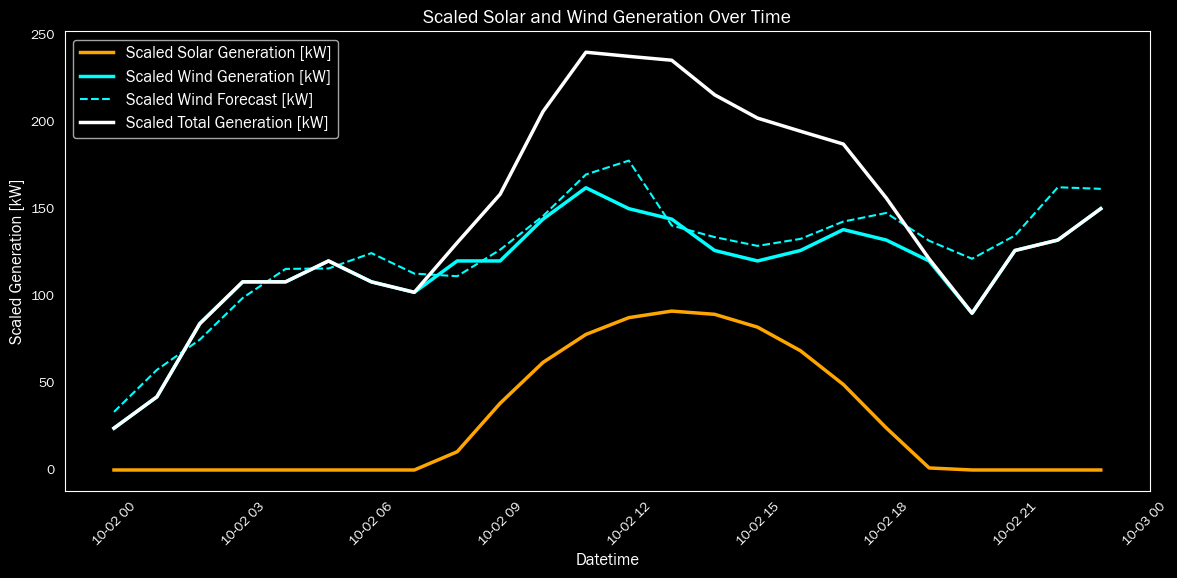

In [29]:
# Plot scaled_solar_generation_kw and scaled_wind_generation_kw
plt.figure(figsize=(12, 6))

# Plot scaled solar generation
plt.plot(
    filtered_merged_data.index,
    scaled_solar_generation_kw,
    label="Scaled Solar Generation [kW]",
    linestyle="-",
    color="orange",
    linewidth=2.5,
)

# Plot scaled wind generation
plt.plot(
    filtered_merged_data.index,
    scaled_wind_generation_kw,
    label="Scaled Wind Generation [kW]",
    linestyle="-",
    color="cyan",
    linewidth=2.5,
)

# Plot scaled wind forecast
plt.plot(
    filtered_merged_data.index,
    scaled_wind_forecast_kw,
    label="Scaled Wind Forecast [kW]",
    linestyle="--",
    color="cyan",
    linewidth=1.5,
)

# Plot scaled total generation
plt.plot(
    filtered_merged_data.index,
    scaled_total_generation_kw,
    label="Scaled Total Generation [kW]",
    linestyle="-",
    color="white",
    linewidth=2.5,
)

# Add axis labels
plt.xlabel("Datetime", fontsize=12, color="white")
plt.ylabel("Scaled Generation [kW]", fontsize=12, color="white")

# Add title
plt.title("Scaled Solar and Wind Generation Over Time", fontsize=14, color="white")

# Customize tick marks
plt.xticks(rotation=45, fontsize=10, color="white")
plt.yticks(fontsize=10, color="white")

# Set the axes lines to white
ax = plt.gca()
ax.spines["bottom"].set_color("white")
ax.spines["top"].set_color("white")
ax.spines["right"].set_color("white")
ax.spines["left"].set_color("white")

# Set the background color of the plot to black
plt.gcf().patch.set_facecolor("black")
ax.set_facecolor("black")

# Add legend
legend = plt.legend(fontsize=12, loc="upper left")
for text in legend.get_texts():
    text.set_color("white")

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## 12-MIN Load Simulation

In [30]:
# Use the value from the "time_step" variable throughout the code
time_step = 12  # minutes

# Generate time intervals for the entire date range
time_intervals = pd.date_range(
    start=filtered_merged_data.index.min(),
    end=filtered_merged_data.index.max(),
    freq=f"{time_step}min",
)

# Repeat each hourly value to match the number of intervals in an hour
repeat_factor = 60 / time_step  # Number of intervals in an hour

# Calculate the number of intervals needed
n_intervals = len(time_intervals)

# Instead of interpolation or np.repeat, repeat each value for each 12-min interval, starting at 0:00
# Each hourly value is repeated at 0:12, 0:24, 0:36, 0:48, and 1:00 (next hour)
# But since 1:00 is the start of the next hour, we want each value to appear at 0:00, 0:12, 0:24, 0:36, 0:48

def repeat_hourly_to_12min(arr, n_intervals):
    # Repeat each value 5 times (for 0:00, 0:12, 0:24, 0:36, 0:48)
    repeated = np.repeat(arr, 5)
    # If there are more intervals than repeated values, pad with the last value
    if len(repeated) < n_intervals:
        pad_length = n_intervals - len(repeated)
        repeated = np.concatenate([repeated, np.full(pad_length, arr[-1])])
    return repeated[:n_intervals]

scaled_total_generation_intervals = repeat_hourly_to_12min(scaled_total_generation_kw, n_intervals)
scaled_wind_generation_intervals = repeat_hourly_to_12min(scaled_wind_generation_kw, n_intervals)
scaled_solar_generation_intervals = repeat_hourly_to_12min(scaled_solar_generation_kw, n_intervals)
scaled_wind_forecast_intervals = repeat_hourly_to_12min(scaled_wind_forecast_kw, n_intervals)

# Save all interval arrays in a DataFrame
generation_intervals_df = pd.DataFrame({
    "datetime": time_intervals,
    "scaled_total_generation_kw": scaled_total_generation_intervals,
    "scaled_wind_generation_kw": scaled_wind_generation_intervals,
    "scaled_solar_generation_kw": scaled_solar_generation_intervals,
    "scaled_wind_forecast_kw": scaled_wind_forecast_intervals,
}).set_index("datetime")

# Extract the date time index from the DataFrame
datetime_index_intervals = generation_intervals_df.index

generation_intervals_df.head(6)

,scaled_total_generation_kw,scaled_wind_generation_kw,scaled_solar_generation_kw,scaled_wind_forecast_kw
datetime,,,,
2024-10-02 00:00:00,24.0000,24.0000,0.0,33.36
2024-10-02 00:12:00,24.0000,24.0000,0.0,33.36
2024-10-02 00:24:00,24.0000,24.0000,0.0,33.36
2024-10-02 00:36:00,24.0000,24.0000,0.0,33.36
2024-10-02 00:48:00,24.0000,24.0000,0.0,33.36
2024-10-02 01:00:00,41.9988,41.9988,0.0,57.48


In [31]:
# Define function to simulate the operation
def simulate_two_electrolyzers_operation_intervals(
    total_generation_kw,
    steady_state_load,
    run_idle_load,
    warm_up_rate,         # kW per hour
    fast_start_up_rate,   # kW per hour
    ramp_down_rate,       # kW per hour
    hydrogen_production_rate,
    time_step,    # 12 minutes = 0.2 hours
):
    """
    Simulates the operation of two electrolyzers based on generation constraints and calculates hydrogen production.
    Supports custom time_step (default 12 min).
    Ramp rates are in kW per hour.
    """

    hydrogen_production = []
    excess_energy = []
    deficit_energy = []

    current_load_e1 = run_idle_load
    current_load_e2 = run_idle_load

    simulated_load_e1 = [current_load_e1]
    simulated_load_e2 = [current_load_e2]

    ramp_type_e1 = []
    ramp_type_e2 = []
    
    idle_time_counter_e1 = 4.1
    idle_time_counter_e2 = 4.1

    for generation in total_generation_kw:
        # Idle time counters
        if current_load_e1 < steady_state_load - 1e-6:
            idle_time_counter_e1 += time_step
        else:
            idle_time_counter_e1 = 0

        if current_load_e2 < steady_state_load - 1e-6:
            idle_time_counter_e2 += time_step
        else:
            idle_time_counter_e2 = 0

        ramp_label_e1 = None
        ramp_label_e2 = None

        if generation >= 2 * steady_state_load:
            # Both at steady-state
            # E1
            if current_load_e1 < steady_state_load:
                ramp_rate_e1 = fast_start_up_rate if idle_time_counter_e1 < 4 else warm_up_rate
                ramp_amount_e1 = ramp_rate_e1 * time_step 
                ramp_needed_e1 = steady_state_load - current_load_e1
                if ramp_needed_e1 <= ramp_amount_e1:
                    hydrogen_e1 = 0
                    current_load_e1 = steady_state_load
                else:
                    hydrogen_e1 = 0
                    current_load_e1 = min(current_load_e1 + ramp_amount_e1, steady_state_load)
                ramp_label_e1 = "fast_start" if ramp_rate_e1 == fast_start_up_rate else "1-hr warm-up"
            else:
                hydrogen_e1 = steady_state_load * time_step * hydrogen_production_rate
                current_load_e1 = steady_state_load
                ramp_label_e1 = None

            # E2
            if current_load_e2 < steady_state_load:
                ramp_rate_e2 = fast_start_up_rate if idle_time_counter_e2 < 4 else warm_up_rate
                ramp_amount_e2 = ramp_rate_e2 * time_step
                ramp_needed_e2 = steady_state_load - current_load_e2
                if ramp_needed_e2 <= ramp_amount_e2:
                    hydrogen_e2 = 0
                    current_load_e2 = steady_state_load
                else:
                    hydrogen_e2 = 0
                    current_load_e2 = min(current_load_e2 + ramp_amount_e2, steady_state_load)
                ramp_label_e2 = "fast_start" if ramp_rate_e2 == fast_start_up_rate else "1-hr warm-up"
            else:
                hydrogen_e2 = steady_state_load * time_step * hydrogen_production_rate
                current_load_e2 = steady_state_load
                ramp_label_e2 = None

            hydrogen_production.append(hydrogen_e1 + hydrogen_e2)
            excess_energy.append(generation - (current_load_e1 + current_load_e2))
            deficit_energy.append(0)

        elif steady_state_load <= generation < 2 * steady_state_load:
            # Only E1 at steady-state
            if current_load_e1 < steady_state_load:
                ramp_rate_e1 = fast_start_up_rate if idle_time_counter_e1 < 4 else warm_up_rate
                ramp_amount_e1 = ramp_rate_e1 * time_step
                ramp_needed_e1 = steady_state_load - current_load_e1
                if ramp_needed_e1 <= ramp_amount_e1:
                    hydrogen_e1 = 0
                    current_load_e1 = steady_state_load
                else:
                    hydrogen_e1 = 0
                    current_load_e1 = min(current_load_e1 + ramp_amount_e1, steady_state_load)
                ramp_label_e1 = "fast_start" if ramp_rate_e1 == fast_start_up_rate else "1-hr warm-up"
            else:
                hydrogen_e1 = steady_state_load * time_step * hydrogen_production_rate
                current_load_e1 = steady_state_load
                ramp_label_e1 = None

            # E2 idle
            if current_load_e2 > run_idle_load:
                ramp_amount_e2 = ramp_down_rate * time_step
                current_load_e2 = max(current_load_e2 - ramp_amount_e2, run_idle_load)
                hydrogen_e2 = 0
                ramp_label_e2 = "ramp_down_to_idle"
            else:
                current_load_e2 = run_idle_load
                hydrogen_e2 = 0
                ramp_label_e2 = None

            hydrogen_production.append(hydrogen_e1 + hydrogen_e2)
            excess_energy.append(generation - current_load_e1)
            deficit_energy.append(0)

        elif run_idle_load <= generation < steady_state_load:
            # Not enough for steady-state
            # E1 ramps down
            if current_load_e1 > generation:
                ramp_amount_e1 = ramp_down_rate * time_step
                ramp_needed_e1 = current_load_e1 - run_idle_load
                if ramp_needed_e1 <= ramp_amount_e1:
                    current_load_e1 = run_idle_load
                    hydrogen_e1 = 0
                else:
                    hydrogen_e1 = 0
                    current_load_e1 = max(current_load_e1 - ramp_amount_e1, run_idle_load)
                ramp_label_e1 = "ramp_down_to_idle"
            else:
                current_load_e1 = run_idle_load
                hydrogen_e1 = 0
                ramp_label_e1 = None

            # E2 ramps down
            if current_load_e2 > run_idle_load:
                ramp_amount_e2 = ramp_down_rate * time_step
                ramp_needed_e2 = current_load_e2 - run_idle_load
                if ramp_needed_e2 <= ramp_amount_e2:
                    current_load_e2 = run_idle_load
                    hydrogen_e2 = 0
                else:
                    hydrogen_e2 = 0
                    current_load_e2 = max(current_load_e2 - ramp_amount_e2, run_idle_load)
                ramp_label_e2 = "ramp_down_to_idle"
            else:
                current_load_e2 = run_idle_load
                hydrogen_e2 = 0
                ramp_label_e2 = None

            hydrogen_production.append(hydrogen_e1 + hydrogen_e2)
            excess_energy.append(0)
            deficit_energy.append(0)

        else:
            # Below run idle
            ramp_amount_e1 = ramp_down_rate * time_step
            ramp_amount_e2 = ramp_down_rate * time_step
            if current_load_e1 > run_idle_load:
                current_load_e1 = max(current_load_e1 - ramp_amount_e1, run_idle_load)
                ramp_label_e1 = "ramp_down_to_idle"
            else:
                current_load_e1 = run_idle_load
                ramp_label_e1 = None

            if current_load_e2 > run_idle_load:
                current_load_e2 = max(current_load_e2 - ramp_amount_e2, run_idle_load)
                ramp_label_e2 = "ramp_down_to_idle"
            else:
                current_load_e2 = run_idle_load
                ramp_label_e2 = None

            hydrogen_production.append(0)
            excess_energy.append(0)
            deficit_energy.append(run_idle_load - generation)

        ramp_type_e1.append(ramp_label_e1)
        ramp_type_e2.append(ramp_label_e2)

        simulated_load_e1.append(current_load_e1)
        simulated_load_e2.append(current_load_e2)

    # Remove the last value to match the length of hydrogen_production, excess_energy, and deficit_energy
    simulated_load_e1 = simulated_load_e1[:-1]
    simulated_load_e2 = simulated_load_e2[:-1]

    return {
        "simulated_load_e1": simulated_load_e1,
        "simulated_load_e2": simulated_load_e2,
        "hydrogen_production": hydrogen_production,
        "excess_energy": excess_energy,
        "deficit_energy": deficit_energy,
        "ramp_type_e1": ramp_type_e1,
        "ramp_type_e2": ramp_type_e2,
    }

In [32]:
# Call the function to simulate two electrolyzers operation at time_step intervals
run_using_combined_generation = simulate_two_electrolyzers_operation_intervals(
    total_generation_kw=scaled_total_generation_intervals,
    steady_state_load=steady_state_load,
    run_idle_load=run_idle_load,
    warm_up_rate=warm_up_rate,
    fast_start_up_rate=fast_start_up_rate,
    ramp_down_rate=ramp_down_rate,
    hydrogen_production_rate=hydrogen_production_rate,
    time_step=time_step / 60,  # 12 minutes
)

run_using_wind_generation = simulate_two_electrolyzers_operation_intervals(
    total_generation_kw=scaled_wind_generation_intervals,
    steady_state_load=steady_state_load,
    run_idle_load=run_idle_load,
    warm_up_rate=warm_up_rate,
    fast_start_up_rate=fast_start_up_rate,
    ramp_down_rate=ramp_down_rate,
    hydrogen_production_rate=hydrogen_production_rate,
    time_step=time_step / 60,
)

run_using_solar_generation = simulate_two_electrolyzers_operation_intervals(
    total_generation_kw=scaled_solar_generation_intervals,
    steady_state_load=steady_state_load,
    run_idle_load=run_idle_load,
    warm_up_rate=warm_up_rate,
    fast_start_up_rate=fast_start_up_rate,
    ramp_down_rate=ramp_down_rate,
    hydrogen_production_rate=hydrogen_production_rate,
    time_step=time_step / 60,
)

# Access combined generation results
simulated_combined_load_e1 = run_using_combined_generation["simulated_load_e1"]
simulated_combined_load_e2 = run_using_combined_generation["simulated_load_e2"]
simulated_combined_hydrogen_production = run_using_combined_generation["hydrogen_production"]
combined_excess_energy = run_using_combined_generation["excess_energy"]
combined_deficit_energy = run_using_combined_generation["deficit_energy"]
combined_ramp_type_e1 = run_using_combined_generation["ramp_type_e1"]
combined_ramp_type_e2 = run_using_combined_generation["ramp_type_e2"]
total_combined_simulated_load = np.array(simulated_combined_load_e1) + np.array(simulated_combined_load_e2)

# Access wind generation results
simulated_wind_load_e1 = run_using_wind_generation["simulated_load_e1"]
simulated_wind_load_e2 = run_using_wind_generation["simulated_load_e2"]
simulated_wind_hydrogen_production = run_using_wind_generation["hydrogen_production"]
wind_excess_energy = run_using_wind_generation["excess_energy"]
wind_deficit_energy = run_using_wind_generation["deficit_energy"]
wind_ramp_type_e1 = run_using_wind_generation["ramp_type_e1"]
wind_ramp_type_e2 = run_using_wind_generation["ramp_type_e2"]
total_wind_simulated_load = np.array(simulated_wind_load_e1) + np.array(simulated_wind_load_e2)

# Access solar generation results
simulated_solar_load_e1 = run_using_solar_generation["simulated_load_e1"]
simulated_solar_load_e2 = run_using_solar_generation["simulated_load_e2"]
simulated_solar_hydrogen_production = run_using_solar_generation["hydrogen_production"]
solar_excess_energy = run_using_solar_generation["excess_energy"]
solar_deficit_energy = run_using_solar_generation["deficit_energy"]
solar_ramp_type_e1 = run_using_solar_generation["ramp_type_e1"]
solar_ramp_type_e2 = run_using_solar_generation["ramp_type_e2"]
total_solar_simulated_load = np.array(simulated_solar_load_e1) + np.array(simulated_solar_load_e2)


In [33]:
from scipy.interpolate import interp1d

# Define the x-coordinates for the original data (hourly points)
x_original = np.arange(len(scaled_total_generation_kw))
x_new = np.linspace(0, len(scaled_total_generation_kw) - 1, len(datetime_index_intervals))

# Interpolate for each time step interval using linear interpolation
interp_total = interp1d(x_original, scaled_total_generation_kw, kind='linear')
interp_wind = interp1d(x_original, scaled_wind_generation_kw, kind='linear')
interp_solar = interp1d(x_original, scaled_solar_generation_kw, kind='linear')

scaled_total_generation_intervals_interp = interp_total(x_new)
scaled_wind_generation_intervals_interp = interp_wind(x_new)
scaled_solar_generation_intervals_interp = interp_solar(x_new)

## Plot Simulation

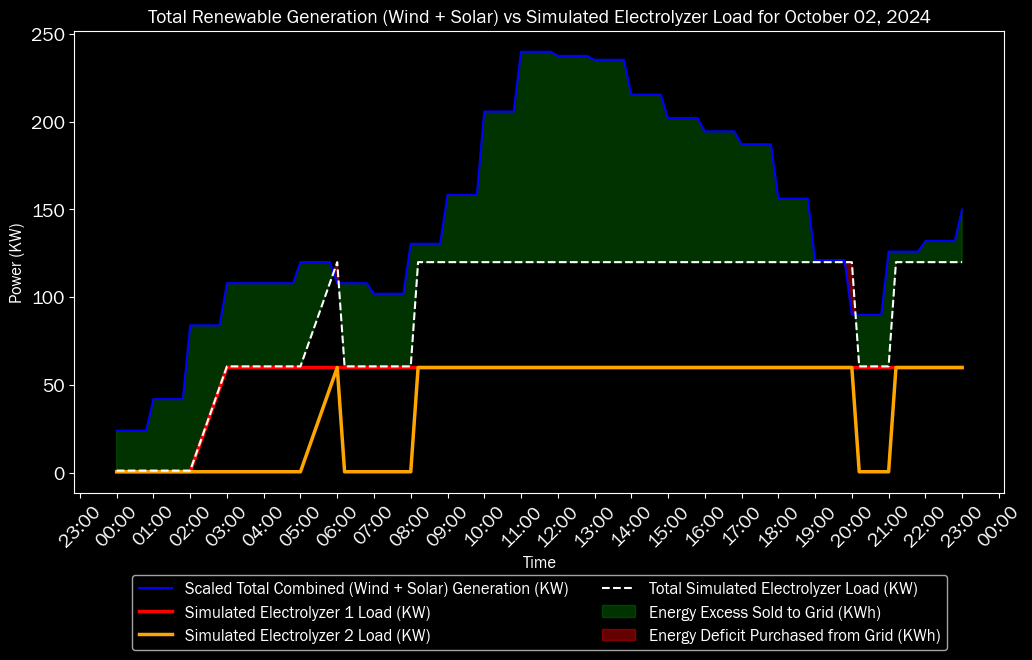

In [34]:
# Plot the simulated load, generation, and hydrogen production
fig, ax1 = plt.subplots(figsize=(12, 6))

# Extract the 'real_time_lmp_price' column
real_time_lmp_price = filtered_merged_data["real-time_lmp_[$/mwh]"]

# # Extract the '5m-real-time_billing_meter_quantity_[mw]' column
# real_time_billing_meter_quantity = filtered_merged_data[
#     "5m-real-time_billing_meter_quantity_[mw]"
# ]

# Plot total generation and simulated load on the primary y-axis
# sns.lineplot(
#     x=filtered_merged_data.index,
#     y=scaled_total_generation_kw,
#     label="Scaled Total Generation (Real Wind + Simulated Solar) (KW)",
#     color="blue",
#     # linestyle="",
#     ax=ax1,
# )

sns.lineplot(
    x=generation_intervals_df.index,
    y=generation_intervals_df["scaled_total_generation_kw"],
    label="Scaled Total Combined (Wind + Solar) Generation (KW)",
    color="blue",
    ax=ax1,
)

sns.lineplot(
    x=datetime_index_intervals,
    y=simulated_combined_load_e1,
    label="Simulated Electrolyzer 1 Load (KW)",
    color="red",
    linewidth=2.5,
    ax=ax1,
)

sns.lineplot(
    x=datetime_index_intervals,
    y=simulated_combined_load_e2,
    label="Simulated Electrolyzer 2 Load (KW)",
    color="orange",
    linewidth=2.5,
    ax=ax1,
)

sns.lineplot(
    x=datetime_index_intervals,
    y=total_combined_simulated_load,
    label="Total Simulated Electrolyzer Load (KW)",
    color="white",
    linestyle="--",
    ax=ax1,
)

ax1.fill_between(
    datetime_index_intervals,
    generation_intervals_df["scaled_total_generation_kw"],
    total_combined_simulated_load,
    where=(generation_intervals_df["scaled_total_generation_kw"] > total_combined_simulated_load),
    interpolate=True,
    color="green",
    alpha=0.4,
    label="Energy Excess Sold to Grid (KWh)",
)
ax1.fill_between(
    datetime_index_intervals,
    generation_intervals_df["scaled_total_generation_kw"],
    total_combined_simulated_load,
    where=(total_combined_simulated_load > generation_intervals_df["scaled_total_generation_kw"]),
    interpolate=True,
    color="red",
    alpha=0.4,
    label="Energy Deficit Purchased from Grid (KWh)",
)

# Set labels and title for the primary y-axis
ax1.set_title(
    f"Total Renewable Generation (Wind + Solar) vs Simulated Electrolyzer Load for {target_day_long_format}",
    fontsize=14,
    color="white",
)
ax1.set_xlabel("Time", fontsize=12, color="white")
ax1.set_ylabel("Power (KW)", fontsize=12, color="white")
ax1.tick_params(axis="x", rotation=45, colors="white")
ax1.tick_params(axis="y", colors="white")

# Set the axes lines to white
ax1.spines["bottom"].set_color("white")
ax1.spines["top"].set_color("white")
ax1.spines["right"].set_color("white")
ax1.spines["left"].set_color("white")

# Set the date format on the x-axis to show hours in 00:00 format
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax1.xaxis.set_major_locator(
    mdates.HourLocator(interval=1)
)  # Set tick marks for every hour

# # Create a secondary y-axis to plot the real-time LMP price
# ax2 = ax1.twinx()
# sns.lineplot(
#     x=filtered_merged_data.index,
#     y=real_time_lmp_price,
#     label="Real-Time LMP Price ($/MWh)",
#     color="yellow",
#     ax=ax2,
# )
# ax2.set_ylabel("Real-Time LMP Price ($/MWh)", fontsize=12, color="yellow")
# ax2.tick_params(axis="y", colors="yellow")

# Combine legends from both y-axes and place them below the plot
lines, labels = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(
    # lines + lines2,
    # labels + labels2,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.16),
    fontsize=12,
    ncol=2,
)

# # Remove the legend box on the top right corner
# ax2.get_legend().remove()

# Set the legend text color to white
for text in legend.get_texts():
    text.set_color("white")

# Show the plot
plt.show()

fig.savefig(f"Combined_wind_solar_generation_vs_simulated_electrolyzer_load_{target_day}.png", dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())

In [35]:
# Create a DataFrame with the index and all simulated loads for each electrolyzer
simulated_loads_df = pd.DataFrame({
    "simulated_combined_load_e1": simulated_combined_load_e1,
    "simulated_combined_load_e2": simulated_combined_load_e2,
    "simulated_combined_load_e1_ramp_type": combined_ramp_type_e1,
    "simulated_combined_load_e2_ramp_type": combined_ramp_type_e2,
    "simulated_combined_hydrogen_production": simulated_combined_hydrogen_production,
    "simulated_wind_load_e1": simulated_wind_load_e1,
    "simulated_wind_load_e2": simulated_wind_load_e2,
    "simulated_wind_load_e1_ramp_type": wind_ramp_type_e1,
    "simulated_wind_load_e2_ramp_type": wind_ramp_type_e2,
    "simulated_wind_hydrogen_production": simulated_wind_hydrogen_production,
    "simulated_solar_load_e1": simulated_solar_load_e1,
    "simulated_solar_load_e2": simulated_solar_load_e2,
    "simulated_solar_load_e1_ramp_type": solar_ramp_type_e1,
    "simulated_solar_load_e2_ramp_type": solar_ramp_type_e2,
    "simulated_solar_hydrogen_production": simulated_solar_hydrogen_production,
}, index=generation_intervals_df.index)


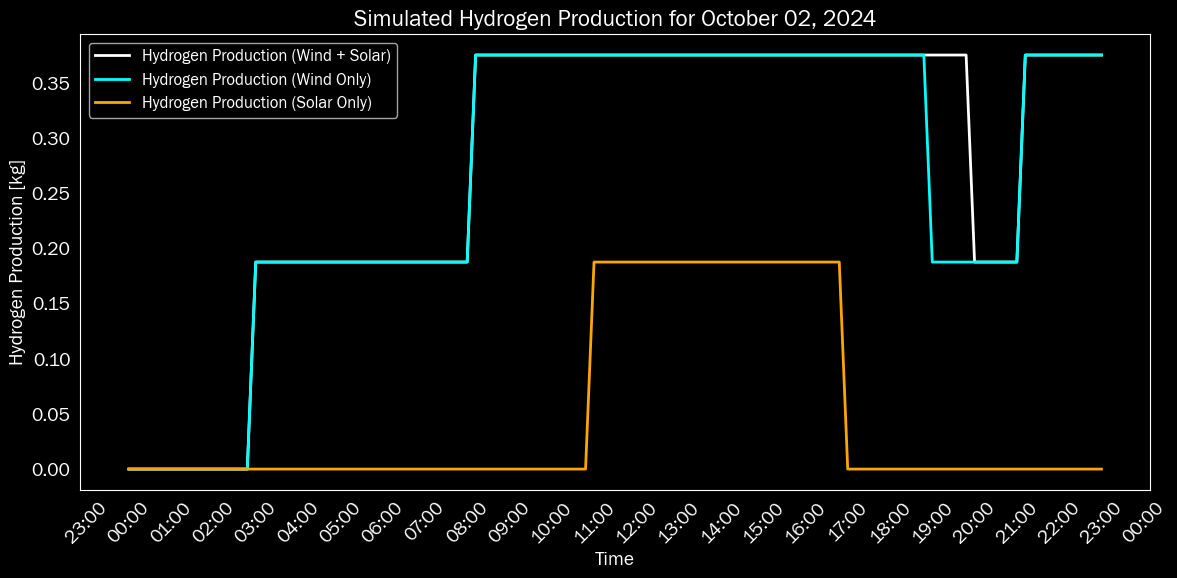

Hydrogen Production (Wind + Solar): 32.0 kg
Hydrogen Production (Wind): 31.0 kg
Hydrogen Production (Solar): 5.6 kg


In [36]:
# Plot hydrogen production for combined, wind, and solar scenarios
plt.figure(figsize=(12, 6))

plt.plot(
    generation_intervals_df.index,
    simulated_combined_hydrogen_production,
    label="Hydrogen Production (Wind + Solar)",
    color="white",
    linestyle="-",
    linewidth=2,
)
plt.plot(
    generation_intervals_df.index,
    simulated_wind_hydrogen_production,
    label="Hydrogen Production (Wind Only)",
    color="cyan",
    linestyle="-",
    linewidth=2,
)
plt.plot(
    generation_intervals_df.index,
    simulated_solar_hydrogen_production,
    label="Hydrogen Production (Solar Only)",
    color="orange",
    linestyle="-",
    linewidth=2,
)

plt.title(f"Simulated Hydrogen Production for {target_day_long_format}", color="white")
plt.xlabel("Time", color="white")
plt.ylabel("Hydrogen Production [kg]", color="white")
plt.xticks(rotation=45, color="white")
plt.yticks(color="white")

ax = plt.gca()
ax.spines["bottom"].set_color("white")
ax.spines["top"].set_color("white")
ax.spines["right"].set_color("white")
ax.spines["left"].set_color("white")
plt.gcf().patch.set_facecolor("black")
ax.set_facecolor("black")

# Set the date format on the x-axis to show hours in 00:00 format
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))

legend = plt.legend(fontsize=12)
for text in legend.get_texts():
    text.set_color("white")

plt.tight_layout()
plt.show() 

# Print total hydrogen production for each scenario
total_simulated_combined_hydrogen_production = sum(simulated_combined_hydrogen_production)  # kg
total_simulated_wind_hydrogen_production = sum(simulated_wind_hydrogen_production)  # kg
total_simulated_solar_hydrogen_production = sum(simulated_solar_hydrogen_production)  # kg

print(f"Hydrogen Production (Wind + Solar): {total_simulated_combined_hydrogen_production:.1f} kg")
print(f"Hydrogen Production (Wind): {total_simulated_wind_hydrogen_production:.1f} kg")
print(f"Hydrogen Production (Solar): {total_simulated_solar_hydrogen_production:.1f} kg")

In [37]:
print(f"Hydrogen Production (Wind + Solar): {total_simulated_combined_hydrogen_production:.1f} kg")
print(f"Hydrogen Production (Wind): {total_simulated_wind_hydrogen_production:.1f} kg")
print(f"Hydrogen Production (Solar): {total_simulated_solar_hydrogen_production:.1f} kg")


theoretical_maximum_hydrogen_production = 2 * steady_state_load * (time_step / 60) * n_intervals * hydrogen_production_rate  # kg of hydrogen
print(f"Theoretical Maximum Hydrogen Production: {theoretical_maximum_hydrogen_production:.1f} kg")

Hydrogen Production (Wind + Solar): 32.0 kg
Hydrogen Production (Wind): 31.0 kg
Hydrogen Production (Solar): 5.6 kg
Theoretical Maximum Hydrogen Production: 43.6 kg


## Export Simulation

In [38]:
# Add hydrogen production columns to the DataFrame before exporting
simulated_loads_df["simulated_combined_hydrogen_production"] = simulated_combined_hydrogen_production
simulated_loads_df["simulated_wind_hydrogen_production"] = simulated_wind_hydrogen_production
simulated_loads_df["simulated_solar_hydrogen_production"] = simulated_solar_hydrogen_production

# Rename columns of simulated_loads_df using a dictionary
rename_dict = {
    "simulated_combined_load_e1": "Combined_E1_Load_kW",
    "simulated_combined_load_e2": "Combined_E2_Load_kW",
    "simulated_combined_load_e1_ramp_type": "Combined_E1_Ramp_Type",
    "simulated_combined_load_e2_ramp_type": "Combined_E2_Ramp_Type",
    "simulated_combined_hydrogen_production": "Combined_Hydrogen_Production_kg",
    "simulated_wind_load_e1": "Wind_E1_Load_kW",
    "simulated_wind_load_e2": "Wind_E2_Load_kW",
    "simulated_wind_load_e1_ramp_type": "Wind_E1_Ramp_Type",
    "simulated_wind_load_e2_ramp_type": "Wind_E2_Ramp_Type",
    "simulated_wind_hydrogen_production": "Wind_Hydrogen_Production_kg",
    "simulated_solar_load_e1": "Solar_E1_Load_kW",
    "simulated_solar_load_e2": "Solar_E2_Load_kW",
    "simulated_solar_load_e1_ramp_type": "Solar_E1_Ramp_Type",
    "simulated_solar_load_e2_ramp_type": "Solar_E2_Ramp_Type",
    "simulated_solar_hydrogen_production": "Solar_Hydrogen_Production_kg",
}
simulated_loads_df.rename(columns=rename_dict, inplace=True)


# Export the DataFrame to an Excel file with different sheets for each scenario
with pd.ExcelWriter(f"simulated_electrolyzer_loads_{time_step}min_{target_day}.xlsx") as writer:
    # Combined scenario
    combined_cols = [
        "Combined_E1_Load_kW",
        "Combined_E2_Load_kW",
        "Combined_E1_Ramp_Type",
        "Combined_E2_Ramp_Type",
        "Combined_Hydrogen_Production_kg",
    ]
    simulated_loads_df[combined_cols].to_excel(writer, sheet_name="Combined", index=True)

    # Wind scenario
    wind_cols = [
        "Wind_E1_Load_kW",
        "Wind_E2_Load_kW",
        "Wind_E1_Ramp_Type",
        "Wind_E2_Ramp_Type",
        "Wind_Hydrogen_Production_kg",
    ]
    simulated_loads_df[wind_cols].to_excel(writer, sheet_name="Wind", index=True)

    # Solar scenario
    solar_cols = [
        "Solar_E1_Load_kW",
        "Solar_E2_Load_kW",
        "Solar_E1_Ramp_Type",
        "Solar_E2_Ramp_Type",
        "Solar_Hydrogen_Production_kg",
    ]
    simulated_loads_df[solar_cols].to_excel(writer, sheet_name="Solar", index=True)

## 1-HR Electrolyzer Load Simulation

In [39]:
# # Electrolyzer simulation function for 1 hour time intervals

# def simulate_two_electrolyzers_operation(
#     total_generation_kw,
#     steady_state_load,
#     run_idle_load,
#     warm_up_rate,
#     fast_start_up_rate,
#     ramp_down_rate,
#     hydrogen_production_rate,
# ):
#     """
#     Simulates the operation of two electrolyzers based on generation constraints and calculates hydrogen production.
#     """
#     # Initialize lists to store results
#     simulated_load_e1 = []
#     simulated_load_e2 = []
#     hydrogen_production = []
#     excess_energy = []
#     deficit_energy = []

#     current_load_e1 = run_idle_load  # Initialize electrolyzer 1 load at run_idle_load
#     current_load_e2 = run_idle_load  # Initialize electrolyzer 2 load at run_idle_load

#     idle_time_counter_e1 = 0  # Counter for idle time of electrolyzer 1
#     idle_time_counter_e2 = 0  # Counter for idle time of electrolyzer 2
#     time_step = 1  # Assuming each time step is 1 hour

#     for generation in total_generation_kw:
#         # Check if electrolyzer 1 and 2 are idle and update their idle time counters
#         # Electrolyzer 1 (E1)
#         if current_load_e1 <= run_idle_load + 1e-6:
#             idle_time_counter_e1 += time_step
#         else:
#             idle_time_counter_e1 = 0

#         # Electrolyzer 2 (E2)
#         if current_load_e2 <= run_idle_load + 1e-6:
#             idle_time_counter_e2 += time_step
#         else:
#             idle_time_counter_e2 = 0

#         if generation >= 2 * steady_state_load:
#             # Both electrolyzers operate at steady-state load
#             # E1
#             if current_load_e1 < steady_state_load:
#                 # E1 ramps up to steady-state load
#                 ramp_rate_e1 = (
#                     fast_start_up_rate
#                     if idle_time_counter_e1 < 4
#                     else warm_up_rate
#                 )
#                 ramp_needed_e1 = steady_state_load - current_load_e1
#                 ramp_time_e1 = ramp_needed_e1 / ramp_rate_e1 # hours to reach steady state
#                 if ramp_time_e1 < 1:
#                     # Part of hour ramping, part at steady state
#                     hydrogen_e1 = steady_state_load * (1 - ramp_time_e1) * hydrogen_production_rate
#                     current_load_e1 = steady_state_load
#                 else:
#                     # Full hour ramping
#                     hydrogen_e1 = 0
#                     current_load_e1 = min(current_load_e1 + ramp_rate_e1, steady_state_load)
#                 idle_time_counter_e1 = 0  # Reset idle time counter
#             else:
#                 # Already at steady state
#                 hydrogen_e1 = steady_state_load * 1 * hydrogen_production_rate # kg_H2: kW * 1 hour * kg/kWh
#                 current_load_e1 = steady_state_load
#                 idle_time_counter_e1 = 0  # Reset idle time counter

#             # E2
#             if current_load_e2 < steady_state_load:
#                 # E2 ramps up to steady-state load
#                 ramp_rate_e2 = (
#                     fast_start_up_rate
#                     if idle_time_counter_e2 < 4
#                     else warm_up_rate
#                 )
#                 ramp_needed_e2 = steady_state_load - current_load_e2
#                 ramp_time_e2 = ramp_needed_e2 / ramp_rate_e2 # hours to reach steady state
#                 if ramp_time_e2 < 1:
#                     # Part of hour ramping, part at steady state
#                     hydrogen_e2 = steady_state_load * (1 - ramp_time_e2) * hydrogen_production_rate
#                     current_load_e2 = steady_state_load
#                 else:
#                     # Full hour ramping
#                     hydrogen_e2 = 0
#                     current_load_e2 = min(current_load_e2 + ramp_rate_e2, steady_state_load)
#                 idle_time_counter_e2 = 0 # Reset idle time counter
#             else:
#                 # Already at steady state
#                 hydrogen_e2 = steady_state_load * 1 * hydrogen_production_rate # kg_H2: kW * 1 hour * kg/kWh
#                 current_load_e2 = steady_state_load
#                 idle_time_counter_e2 = 0

#             # Total hydrogen production
#             hydrogen_production.append(hydrogen_e1 + hydrogen_e2)

#             # Excess energy is sold to the grid
#             excess_energy.append(generation - (current_load_e1 + current_load_e2))
#             deficit_energy.append(0)

#         elif steady_state_load <= generation < 2 * steady_state_load:
#             # Only E1 operates at steady-state load
#             if current_load_e1 < steady_state_load:
#                 ramp_rate_e1 = (
#                     fast_start_up_rate
#                     if idle_time_counter_e1 < 4
#                     else warm_up_rate
#                 )
#                 ramp_needed_e1 = steady_state_load - current_load_e1
#                 ramp_time_e1 = ramp_needed_e1 / ramp_rate_e1 # hours to reach steady state
#                 if ramp_time_e1 < 1:
#                     # Part of hour ramping, part at steady state
#                     hydrogen_e1 = steady_state_load * (1 - ramp_time_e1) * hydrogen_production_rate
#                     current_load_e1 = steady_state_load
#                 else:
#                     # Full hour ramping
#                     hydrogen_e1 = 0
#                     current_load_e1 = min(current_load_e1 + ramp_rate_e1, steady_state_load)
#                 idle_time_counter_e1 = 0
#             else:
#                 # Already at steady state
#                 hydrogen_e1 = steady_state_load * 1 * hydrogen_production_rate # kg_H2: kW * 1 hour * kg/kWh
#                 current_load_e1 = steady_state_load
#                 idle_time_counter_e1 = 0

#             # E2 remains idle
#             if current_load_e2 > run_idle_load:
#                 current_load_e2 = max(current_load_e2 - ramp_down_rate, run_idle_load)
#                 hydrogen_e2 = 0
#             else:
#                 current_load_e2 = run_idle_load
#                 hydrogen_e2 = 0

#             hydrogen_production.append(hydrogen_e1+hydrogen_e2)

#             # Excess energy is sold to the grid
#             excess_energy.append(generation - current_load_e1)
#             deficit_energy.append(0)

#         elif run_idle_load <= generation < steady_state_load:
#             # Generation is insufficient for steady-state load
#             # E1 ramps down to run idle load
#             if current_load_e1 > generation:
#                 ramp_needed_e1 = current_load_e1 - run_idle_load
#                 ramp_time_e1 = ramp_needed_e1 / ramp_down_rate if ramp_needed_e1 > 0 else 1
#                 if ramp_time_e1 < 1:
#                     # Part of hour ramping, part at run idle load
#                     current_load_e1 = run_idle_load
#                     hydrogen_e1 = 0
#                 else:
#                     # Full hour ramping
#                     hydrogen_e1 = 0
#                     current_load_e1 = max(current_load_e1 - ramp_down_rate, run_idle_load)
#             else:
#                 current_load_e1 = run_idle_load
#                 hydrogen_e1 = 0

#             # E2 ramps down to run idle load
#             if current_load_e2 > run_idle_load:
#                 ramp_needed_e2 = current_load_e2 - run_idle_load
#                 ramp_time_e2 = ramp_needed_e2 / ramp_down_rate if ramp_needed_e2 > 0 else 1
#                 if ramp_time_e2 < 1:
#                     # Part of hour ramping, part at run idle load
#                     current_load_e2 = run_idle_load
#                     hydrogen_e2 = 0
#                 else:
#                     # Full hour ramping
#                     hydrogen_e2 = 0
#                     current_load_e2 = max(current_load_e2 - ramp_down_rate, run_idle_load)
#                 current_load_e2 = max(current_load_e2 - ramp_down_rate, run_idle_load)
#             else:
#                 current_load_e2 = run_idle_load
#                 hydrogen_e2 = 0

#             hydrogen_production.append(hydrogen_e1 + hydrogen_e2)

#             # No excess or deficit energy
#             excess_energy.append(0)
#             deficit_energy.append(0)

#         else:
#             # Generation is below run idle load
#             if current_load_e1 > run_idle_load:
#                 current_load_e1 = max(current_load_e1 - ramp_down_rate, run_idle_load)
#             else:
#                 current_load_e1 = run_idle_load

#             if current_load_e2 > run_idle_load:
#                 current_load_e2 = max(current_load_e2 - ramp_down_rate, run_idle_load)
#             else:
#                 current_load_e2 = run_idle_load

#             hydrogen_production.append(0)

#             # Deficit energy is purchased from the grid
#             excess_energy.append(0)
#             deficit_energy.append(run_idle_load - generation)

#         # Append the current loads to the simulated load lists
#         simulated_load_e1.append(current_load_e1)
#         simulated_load_e2.append(current_load_e2)

#     return {
#         "simulated_load_e1": simulated_load_e1,
#         "simulated_load_e2": simulated_load_e2,
#         "hydrogen_production": hydrogen_production,
#         "excess_energy": excess_energy,
#         "deficit_energy": deficit_energy,
#     }

In [40]:
# # Call the function to simulate two electrolyzers operation
# run_using_combined_generation = simulate_two_electrolyzers_operation(
#     total_generation_kw=scaled_total_generation_kw,
#     steady_state_load=steady_state_load,
#     run_idle_load=run_idle_load,
#     warm_up_rate=warm_up_rate,
#     fast_start_up_rate=fast_start_up_rate,
#     ramp_down_rate=ramp_down_rate,
#     hydrogen_production_rate=hydrogen_production_rate,
# )

# run_using_wind_generation = simulate_two_electrolyzers_operation(
#     total_generation_kw=scaled_wind_generation_kw,
#     steady_state_load=steady_state_load,
#     run_idle_load=run_idle_load,
#     warm_up_rate=warm_up_rate,
#     fast_start_up_rate=fast_start_up_rate,
#     ramp_down_rate=ramp_down_rate,
#     hydrogen_production_rate=hydrogen_production_rate,
# )

# run_using_solar_generation = simulate_two_electrolyzers_operation(
#     total_generation_kw=scaled_solar_generation_kw,
#     steady_state_load=steady_state_load,
#     run_idle_load=run_idle_load,
#     warm_up_rate=warm_up_rate,
#     fast_start_up_rate=fast_start_up_rate,
#     ramp_down_rate=ramp_down_rate,
#     hydrogen_production_rate=hydrogen_production_rate,
# )

# # Access combined generation results
# simulated_combined_load_e1 = run_using_combined_generation["simulated_load_e1"]
# simulated_combined_load_e2 = run_using_combined_generation["simulated_load_e2"]
# simulated_combined_hydrogen_production = run_using_combined_generation["hydrogen_production"]
# combined_excess_energy = run_using_combined_generation["excess_energy"]
# combined_deficit_energy = run_using_combined_generation["deficit_energy"]
# total_combined_simulated_load = np.array(simulated_combined_load_e1) + np.array(simulated_combined_load_e2)

# # Access wind generation results
# simulated_wind_load_e1 = run_using_wind_generation["simulated_load_e1"]
# simulated_wind_load_e2 = run_using_wind_generation["simulated_load_e2"]
# simulated_wind_hydrogen_production = run_using_wind_generation["hydrogen_production"]
# wind_excess_energy = run_using_wind_generation["excess_energy"]
# wind_deficit_energy = run_using_wind_generation["deficit_energy"]
# total_wind_simulated_load = np.array(simulated_wind_load_e1) + np.array(simulated_wind_load_e2)

# # Access solar generation results
# simulated_solar_load_e1 = run_using_solar_generation["simulated_load_e1"]
# simulated_solar_load_e2 = run_using_solar_generation["simulated_load_e2"]
# simulated_solar_hydrogen_production = run_using_solar_generation["hydrogen_production"]
# solar_excess_energy = run_using_solar_generation["excess_energy"]
# solar_deficit_energy = run_using_solar_generation["deficit_energy"]
# total_solar_simulated_load = np.array(simulated_solar_load_e1) + np.array(simulated_solar_load_e2)


In [41]:
# # Plot the simulated load, generation, and hydrogen production
# fig, ax1 = plt.subplots(figsize=(12, 6))

# # Extract the 'real_time_lmp_price' column
# real_time_lmp_price = filtered_merged_data["real-time_lmp_[$/mwh]"]

# # # Extract the '5m-real-time_billing_meter_quantity_[mw]' column
# # real_time_billing_meter_quantity = filtered_merged_data[
# #     "5m-real-time_billing_meter_quantity_[mw]"
# # ]

# # Plot total generation and simulated load on the primary y-axis
# sns.lineplot(
#     x=filtered_merged_data.index,
#     y=scaled_total_generation_kw,
#     label="Scaled Total Generation (Real Wind + Simulated Solar) (KW)",
#     color="blue",
#     # linestyle="",
#     ax=ax1,
# )

# # sns.lineplot(
# #     x=filtered_merged_data.index,
# #     y=scaled_solar_generation_kw,
# #     label="Scaled Simulated Solar Generation (KW)",
# #     color="orange",
# #     linestyle="--",
# #     ax=ax1,
# # )

# # sns.lineplot(
# #     x=filtered_merged_data.index,
# #     y=scaled_wind_generation_kw,
# #     label="Scaled Real Wind Generation (KW)",
# #     color="cyan",
# #     linestyle="--",
# #     ax=ax1,
# # )

# sns.lineplot(
#     x=filtered_merged_data.index,
#     y=simulated_combined_load_e1,
#     label="Simulated Electrolyzer 1 Load (KW)",
#     color="red",
#     linewidth=2.5,
#     ax=ax1,
# )

# sns.lineplot(
#     x=filtered_merged_data.index,
#     y=simulated_combined_load_e2,
#     label="Simulated Electrolyzer 2 Load (KW)",
#     color="orange",
#     linewidth=2.5,
#     ax=ax1,
# )

# sns.lineplot(
#     x=filtered_merged_data.index,
#     y=total_combined_simulated_load,
#     label="Total Simulated Electrolyzer Load (KW)",
#     color="white",
#     linestyle="--",
#     ax=ax1,
# )

# # sns.lineplot(
# #     x=filtered_merged_data.index,
# #     y=scaled_wind_forecast_kw,
# #     label="Scaled Forecasted Wind Generation (KW)",
# #     linestyle=":",
# #     color="white",
# #     ax=ax1,
# # )

# # sns.lineplot(
# #     x=filtered_merged_data.index,
# #     y=real_time_billing_meter_quantity,
# #     label="5-Min Real Wind Generation (KW)",
# #     linestyle=":",
# #     color="cyan",
# #     ax=ax1,
# # )

# # Shade the area between the curves
# ax1.fill_between(
#     filtered_merged_data.index,
#     scaled_total_generation_kw,
#     total_combined_simulated_load,
#     where=(scaled_total_generation_kw > total_combined_simulated_load),
#     interpolate=True,
#     color="green",
#     alpha=0.4,
#     label="Energy Excess Sold to Grid (KWh)",
# )
# ax1.fill_between(
#     filtered_merged_data.index,
#     scaled_total_generation_kw,
#     total_combined_simulated_load,
#     where=(total_combined_simulated_load > scaled_total_generation_kw),
#     interpolate=True,
#     color="red",
#     alpha=0.4,
#     label="Energy Deficit Purchased from Grid (KWh)",
# )

# # Set labels and title for the primary y-axis
# ax1.set_title(
#     f"Total Generation vs Simulated Load for {target_day_long_format}",
#     fontsize=14,
#     color="white",
# )
# ax1.set_xlabel("Time", fontsize=12, color="white")
# ax1.set_ylabel("Power (KW)", fontsize=12, color="white")
# ax1.tick_params(axis="x", rotation=45, colors="white")
# ax1.tick_params(axis="y", colors="white")

# # Set the axes lines to white
# ax1.spines["bottom"].set_color("white")
# ax1.spines["top"].set_color("white")
# ax1.spines["right"].set_color("white")
# ax1.spines["left"].set_color("white")

# # Set the date format on the x-axis to show hours in 00:00 format
# ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
# ax1.xaxis.set_major_locator(
#     mdates.HourLocator(interval=1)
# )  # Set tick marks for every hour

# # # Create a secondary y-axis to plot the real-time LMP price
# # ax2 = ax1.twinx()
# # sns.lineplot(
# #     x=filtered_merged_data.index,
# #     y=real_time_lmp_price,
# #     label="Real-Time LMP Price ($/MWh)",
# #     color="yellow",
# #     ax=ax2,
# # )
# # ax2.set_ylabel("Real-Time LMP Price ($/MWh)", fontsize=12, color="yellow")
# # ax2.tick_params(axis="y", colors="yellow")

# # Combine legends from both y-axes and place them below the plot
# lines, labels = ax1.get_legend_handles_labels()
# # lines2, labels2 = ax2.get_legend_handles_labels()
# legend = ax1.legend(
#     # lines + lines2,
#     # labels + labels2,
#     loc="upper center",
#     bbox_to_anchor=(0.5, -0.16),
#     fontsize=12,
#     ncol=2,
# )

# # # Remove the legend box on the top right corner
# # ax2.get_legend().remove()

# # Set the legend text color to white
# for text in legend.get_texts():
#     text.set_color("white")

# # Show the plot
# plt.show()

In [42]:
# # Plot the simulated load, generation, and hydrogen production
# fig, ax1 = plt.subplots(figsize=(12, 6))

# # Extract the 'real_time_lmp_price' column
# real_time_lmp_price = filtered_merged_data["real-time_lmp_[$/mwh]"]

# # # Extract the '5m-real-time_billing_meter_quantity_[mw]' column
# # real_time_billing_meter_quantity = filtered_merged_data[
# #     "5m-real-time_billing_meter_quantity_[mw]"
# # ]

# # Plot total generation and simulated load on the primary y-axis
# sns.lineplot(
#     x=filtered_merged_data.index,
#     y=scaled_total_generation_kw,
#     label="Scaled Total Generation (Real Wind + Simulated Solar) (KW)",
#     color="blue",
#     # linestyle="",
#     ax=ax1,
# )

# # sns.lineplot(
# #     x=filtered_merged_data.index,
# #     y=scaled_solar_generation_kw,
# #     label="Scaled Simulated Solar Generation (KW)",
# #     color="orange",
# #     linestyle="--",
# #     ax=ax1,
# # )

# # sns.lineplot(
# #     x=filtered_merged_data.index,
# #     y=scaled_wind_generation_kw,
# #     label="Scaled Real Wind Generation (KW)",
# #     color="cyan",
# #     linestyle="--",
# #     ax=ax1,
# # )

# sns.lineplot(
#     x=filtered_merged_data.index,
#     y=simulated_combined_load_e1,
#     label="Simulated Electrolyzer 1 Load (KW)",
#     color="red",
#     linewidth=2.5,
#     ax=ax1,
# )

# sns.lineplot(
#     x=filtered_merged_data.index,
#     y=simulated_combined_load_e2,
#     label="Simulated Electrolyzer 2 Load (KW)",
#     color="orange",
#     linewidth=2.5,
#     ax=ax1,
# )

# sns.lineplot(
#     x=filtered_merged_data.index,
#     y=total_combined_simulated_load,
#     label="Total Simulated Electrolyzer Load (KW)",
#     color="white",
#     linestyle="--",
#     ax=ax1,
# )

# # sns.lineplot(
# #     x=filtered_merged_data.index,
# #     y=scaled_wind_forecast_kw,
# #     label="Scaled Forecasted Wind Generation (KW)",
# #     linestyle=":",
# #     color="white",
# #     ax=ax1,
# # )

# # sns.lineplot(
# #     x=filtered_merged_data.index,
# #     y=real_time_billing_meter_quantity,
# #     label="5-Min Real Wind Generation (KW)",
# #     linestyle=":",
# #     color="cyan",
# #     ax=ax1,
# # )

# # Shade the area between the curves
# ax1.fill_between(
#     filtered_merged_data.index,
#     scaled_total_generation_kw,
#     total_combined_simulated_load,
#     where=(scaled_total_generation_kw > total_combined_simulated_load),
#     interpolate=True,
#     color="green",
#     alpha=0.4,
#     label="Energy Excess Sold to Grid (KWh)",
# )
# ax1.fill_between(
#     filtered_merged_data.index,
#     scaled_total_generation_kw,
#     total_combined_simulated_load,
#     where=(total_combined_simulated_load > scaled_total_generation_kw),
#     interpolate=True,
#     color="red",
#     alpha=0.4,
#     label="Energy Deficit Purchased from Grid (KWh)",
# )

# # Set labels and title for the primary y-axis
# ax1.set_title(
#     f"Total Generation vs Simulated Load for {target_day_long_format}",
#     fontsize=14,
#     color="white",
# )
# ax1.set_xlabel("Time", fontsize=12, color="white")
# ax1.set_ylabel("Power (KW)", fontsize=12, color="white")
# ax1.tick_params(axis="x", rotation=45, colors="white")
# ax1.tick_params(axis="y", colors="white")

# # Set the axes lines to white
# ax1.spines["bottom"].set_color("white")
# ax1.spines["top"].set_color("white")
# ax1.spines["right"].set_color("white")
# ax1.spines["left"].set_color("white")

# # Set the date format on the x-axis to show hours in 00:00 format
# ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
# ax1.xaxis.set_major_locator(
#     mdates.HourLocator(interval=1)
# )  # Set tick marks for every hour

# # # Create a secondary y-axis to plot the real-time LMP price
# # ax2 = ax1.twinx()
# # sns.lineplot(
# #     x=filtered_merged_data.index,
# #     y=real_time_lmp_price,
# #     label="Real-Time LMP Price ($/MWh)",
# #     color="yellow",
# #     ax=ax2,
# # )
# # ax2.set_ylabel("Real-Time LMP Price ($/MWh)", fontsize=12, color="yellow")
# # ax2.tick_params(axis="y", colors="yellow")

# # Combine legends from both y-axes and place them below the plot
# lines, labels = ax1.get_legend_handles_labels()
# # lines2, labels2 = ax2.get_legend_handles_labels()
# legend = ax1.legend(
#     # lines + lines2,
#     # labels + labels2,
#     loc="upper center",
#     bbox_to_anchor=(0.5, -0.16),
#     fontsize=12,
#     ncol=2,
# )

# # # Remove the legend box on the top right corner
# # ax2.get_legend().remove()

# # Set the legend text color to white
# for text in legend.get_texts():
#     text.set_color("white")

# # Show the plot
# plt.show()

In [43]:
# # Plot the simulated wind generation and load
# fig, ax1 = plt.subplots(figsize=(12, 6))

# # Plot scaled wind generation
# sns.lineplot(
#     x=filtered_merged_data.index,
#     y=scaled_wind_generation_kw,
#     label="Scaled Real Wind Generation (KW)",
#     color="blue",
#     linestyle="--",
#     ax=ax1,
# )

# # Plot simulated wind load for Electrolyzer 1
# sns.lineplot(
#     x=filtered_merged_data.index,
#     y=simulated_wind_load_e1,
#     label="Simulated Wind Electrolyzer 1 Load (KW)",
#     color="red",
#     linewidth=2.5,
#     ax=ax1,
# )

# # Plot simulated wind load for Electrolyzer 2
# sns.lineplot(
#     x=filtered_merged_data.index,
#     y=simulated_wind_load_e2,
#     label="Simulated Wind Electrolyzer 2 Load (KW)",
#     color="orange",
#     linewidth=2.5,
#     ax=ax1,
# )

# # Plot total simulated wind load
# sns.lineplot(
#     x=filtered_merged_data.index,
#     y=total_wind_simulated_load,
#     label="Total Simulated Wind Electrolyzer Load (KW)",
#     color="white",
#     linestyle="--",
#     ax=ax1,
# )

# # Shade the area between the curves
# ax1.fill_between(
#     filtered_merged_data.index,
#     scaled_wind_generation_kw,
#     total_wind_simulated_load,
#     where=(scaled_wind_generation_kw > total_wind_simulated_load),
#     interpolate=True,
#     color="green",
#     alpha=0.4,
#     label="Wind Energy Excess Sold to Grid (KWh)",
# )
# ax1.fill_between(
#     filtered_merged_data.index,
#     scaled_wind_generation_kw,
#     total_wind_simulated_load,
#     where=(total_wind_simulated_load > scaled_wind_generation_kw),
#     interpolate=True,
#     color="red",
#     alpha=0.4,
#     label="Wind Energy Deficit Purchased from Grid (KWh)",
# )

# # Set labels and title for the primary y-axis
# ax1.set_title(
#     f"Wind Generation vs Simulated Load for {target_day_long_format}",
#     fontsize=14,
#     color="white",
# )
# ax1.set_xlabel("Time", fontsize=12, color="white")
# ax1.set_ylabel("Power (KW)", fontsize=12, color="white")
# ax1.tick_params(axis="x", rotation=45, colors="white")
# ax1.tick_params(axis="y", colors="white")

# # Set the axes lines to white
# ax1.spines["bottom"].set_color("white")
# ax1.spines["top"].set_color("white")
# ax1.spines["right"].set_color("white")
# ax1.spines["left"].set_color("white")

# # Set the date format on the x-axis to show hours in 00:00 format
# ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
# ax1.xaxis.set_major_locator(
#     mdates.HourLocator(interval=1)
# )  # Set tick marks for every hour

# # Combine legends and place them below the plot
# lines, labels = ax1.get_legend_handles_labels()
# legend = ax1.legend(
#     loc="upper center",
#     bbox_to_anchor=(0.5, -0.16),
#     fontsize=12,
#     ncol=2,
# )

# # Set the legend text color to white
# for text in legend.get_texts():
#     text.set_color("white")

# # Show the plot
# plt.show()


In [44]:
# # Plot the simulated solar generation and load
# fig, ax1 = plt.subplots(figsize=(12, 6))

# # Plot scaled solar generation
# sns.lineplot(
#     x=filtered_merged_data.index,
#     y=scaled_solar_generation_kw,
#     label="Scaled Simulated Solar Generation (KW)",
#     color="blue",
#     linestyle="--",
#     ax=ax1,
# )

# # Plot simulated solar load for Electrolyzer 1
# sns.lineplot(
#     x=filtered_merged_data.index,
#     y=simulated_solar_load_e1,
#     label="Simulated Solar Electrolyzer 1 Load (KW)",
#     color="red",
#     linewidth=2.5,
#     ax=ax1,
# )

# # Plot simulated solar load for Electrolyzer 2
# sns.lineplot(
#     x=filtered_merged_data.index,
#     y=simulated_solar_load_e2,
#     label="Simulated Solar Electrolyzer 2 Load (KW)",
#     color="orange",
#     linewidth=2.5,
#     ax=ax1,
# )

# # Plot total simulated solar load
# sns.lineplot(
#     x=filtered_merged_data.index,
#     y=total_solar_simulated_load,
#     label="Total Simulated Solar Electrolyzer Load (KW)",
#     color="white",
#     linestyle="--",
#     ax=ax1,
# )

# # Shade the area between the curves
# ax1.fill_between(
#     filtered_merged_data.index,
#     scaled_solar_generation_kw,
#     total_solar_simulated_load,
#     where=(scaled_solar_generation_kw > total_solar_simulated_load),
#     interpolate=True,
#     color="green",
#     alpha=0.4,
#     label="Solar Energy Excess Sold to Grid (KWh)",
# )
# ax1.fill_between(
#     filtered_merged_data.index,
#     scaled_solar_generation_kw,
#     total_solar_simulated_load,
#     where=(total_solar_simulated_load > scaled_solar_generation_kw),
#     interpolate=True,
#     color="red",
#     alpha=0.4,
#     label="Solar Energy Deficit Purchased from Grid (KWh)",
# )

# # Set labels and title for the primary y-axis
# ax1.set_title(
#     f"Solar Generation vs Simulated Load for {target_day_long_format}",
#     fontsize=14,
#     color="white",
# )
# ax1.set_xlabel("Time", fontsize=12, color="white")
# ax1.set_ylabel("Power (KW)", fontsize=12, color="white")
# ax1.tick_params(axis="x", rotation=45, colors="white")
# ax1.tick_params(axis="y", colors="white")

# # Set the axes lines to white
# ax1.spines["bottom"].set_color("white")
# ax1.spines["top"].set_color("white")
# ax1.spines["right"].set_color("white")
# ax1.spines["left"].set_color("white")

# # Set the date format on the x-axis to show hours in 00:00 format
# ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
# ax1.xaxis.set_major_locator(
#     mdates.HourLocator(interval=1)
# )  # Set tick marks for every hour

# # Combine legends and place them below the plot
# lines, labels = ax1.get_legend_handles_labels()
# legend = ax1.legend(
#     loc="upper center",
#     bbox_to_anchor=(0.5, -0.16),
#     fontsize=12,
#     ncol=2,
# )

# # Set the legend text color to white
# for text in legend.get_texts():
#     text.set_color("white")

# # Show the plot
# plt.show()

In [45]:
# # Plot the simulated load and hydrogen production
# fig, ax1 = plt.subplots(figsize=(12, 6))

# # Plot simulated load on the left y-axis
# ax1.plot(
#     filtered_merged_data.index,
#     total_combined_simulated_load,
#     label="Total Simulated Load (Wind + Solar) (KW)",
#     linestyle="-",
#     color="white",
#     linewidth=2.5,
# )

# # Plot total solar simulated load
# ax1.plot(
#     filtered_merged_data.index,
#     total_solar_simulated_load,
#     label="Total Simulated Load (Solar) (KW)",
#     linestyle="-",
#     color="orange",
#     linewidth=2.5,
# )

# # Plot total wind simulated load
# ax1.plot(
#     filtered_merged_data.index,
#     total_wind_simulated_load,
#     label="Total Simulated Load (Wind) (KW)",
#     linestyle="-",
#     color="cyan",
#     linewidth=2.5,
# )
# ax1.set_xlabel("Time", fontsize=14, color="white")
# ax1.set_ylabel("Simulated Load [KW]", fontsize=14, color="white")
# ax1.tick_params(axis="x", rotation=45, colors="white")
# ax1.tick_params(axis="y", colors="white")
# ax1.spines["bottom"].set_color("white")
# ax1.spines["top"].set_color("white")
# ax1.spines["right"].set_color("white")
# ax1.spines["left"].set_color("white")

# # Set the x-axis to display hours in 00:00 format
# ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
# ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1))

# # Set the background color of the plot to black
# plt.gcf().patch.set_facecolor("black")
# ax1.set_facecolor("black")

# # Create a second y-axis for hydrogen production
# ax2 = ax1.twinx()

# # Plot hydrogen production for combined generation
# ax2.plot(
#     filtered_merged_data.index,
#     simulated_combined_hydrogen_production,
#     label="Hydrogen Production (Wind + Solar) (kg)",
#     linestyle="--",
#     color="white",
#     linewidth=2,
# )

# # Plot hydrogen production for solar generation
# ax2.plot(
#     filtered_merged_data.index,
#     simulated_solar_hydrogen_production,
#     label="Hydrogen Production (Solar) (kg)",
#     linestyle="--",
#     color="orange",
#     linewidth=2,
# )

# # Plot hydrogen production for wind generation
# ax2.plot(
#     filtered_merged_data.index,
#     simulated_wind_hydrogen_production,
#     label="Hydrogen Production (Wind) (kg)",
#     linestyle="--",
#     color="cyan",
#     linewidth=2,
# )

# ax2.set_ylabel("Hydrogen Production [kg]", fontsize=12, color="yellow")
# ax2.tick_params(axis="y", colors="yellow")

# # Combine legends from both axes
# lines1, labels1 = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# legend = ax1.legend(
#     lines1 + lines2,
#     labels1 + labels2,
#     loc="upper center",
#     bbox_to_anchor=(0.5, -0.15),
#     fontsize=14,
#     ncol=2,
# )

# # Set the legend text color to white
# for text in legend.get_texts():
#     text.set_color("white")

# plt.title(f"Simulated Load and Hydrogen Production for {target_day_long_format}", fontsize=14, color="white")
# plt.tight_layout()  # Adjust layout to prevent overlap
# plt.show()

# # Print total hydrogen production for each scenario
# total_simulated_combined_hydrogen_production = sum(simulated_combined_hydrogen_production)  # kg
# total_simulated_wind_hydrogen_production = sum(simulated_wind_hydrogen_production)  # kg
# total_simulated_solar_hydrogen_production = sum(simulated_solar_hydrogen_production)  # kg

# print(f"Total Hydrogen Production (Wind + Solar): {total_simulated_combined_hydrogen_production:.2f} kg")
# print(f"Total Hydrogen Production (Wind): {total_simulated_wind_hydrogen_production:.2f} kg")
# print(f"Total Hydrogen Production (Solar): {total_simulated_solar_hydrogen_production:.2f} kg")

In [46]:
# # Print maximum theoretical hydrogen production
# max_theoretical_hydrogen_production = 2 * (steady_state_load * len(filtered_merged_data.index)) * hydrogen_production_rate
# # kg_H2: kW * hours * kg/kWh

# print(f"Maximum Theoretical Hydrogen Production: {max_theoretical_hydrogen_production:.2f} kg")

In [47]:
# # Create a DataFrame with the filtered_merged_data index and all simulated loads for each electrolyzer
# simulated_loads_df = pd.DataFrame({
#     "simulated_combined_load_e1": simulated_combined_load_e1,
#     "simulated_combined_load_e2": simulated_combined_load_e2,
#     "simulated_wind_load_e1": simulated_wind_load_e1,
#     "simulated_wind_load_e2": simulated_wind_load_e2,
#     "simulated_solar_load_e1": simulated_solar_load_e1,
#     "simulated_solar_load_e2": simulated_solar_load_e2,
# }, index=filtered_merged_data.index)

# # Create a dictionary mapping load values to descriptive labels
# load_status_dict = {
#     60: "steady-state full load",
#     0.65: "run-idle load"
# }

# # Add load status columns for each electrolyzer (combined, wind, solar)
# for load_type in ["combined", "wind", "solar"]:
#     for electrolyzer in ["e1", "e2"]:
#         column_name = f"simulated_{load_type}_load_{electrolyzer}"
#         load_status_column_name = f"{load_type}_load_status_{electrolyzer}"
#         simulated_loads_df[load_status_column_name] = simulated_loads_df[column_name].map(load_status_dict)

# # Export the simulated loads DataFrame to an Excel file
# simulated_loads_df.to_csv(f"simulated_electrolyzer_loads_{target_day}.csv", index=True)



# Calculate Simulated Energy Deficits & Excess and Associated Cost

Note: Revision required as of May 6, 2025

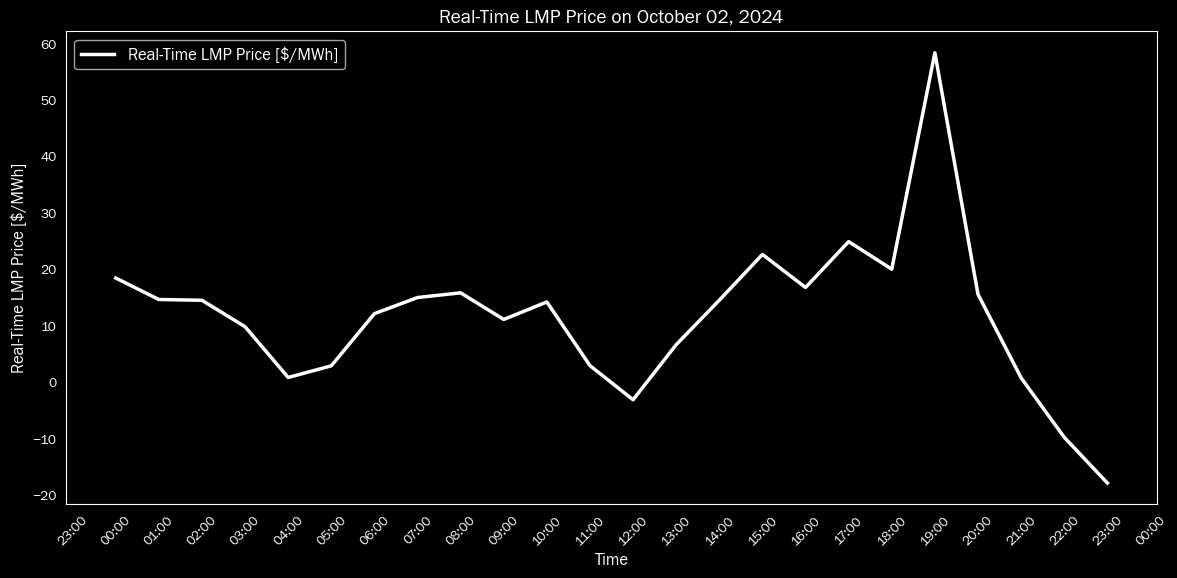

In [54]:
# Plot real-time LMP price for the target day
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=filtered_merged_data,
    x=filtered_merged_data.index,
    y="real-time_lmp_[$/mwh]",
    color="white",
    linewidth=2.5,
    label="Real-Time LMP Price [$/MWh]",
)
plt.title(
    f"Real-Time LMP Price on {target_day_long_format}",
    fontsize=14,
    color="white"
)
plt.xlabel("Time", fontsize=12, color="white")
plt.ylabel("Real-Time LMP Price [$/MWh]", fontsize=12, color="white")
plt.xticks(rotation=45, fontsize=10, color="white")
plt.yticks(fontsize=10, color="white")

# Set the axes lines to white
ax = plt.gca()
ax.spines["bottom"].set_color("white")
ax.spines["top"].set_color("white")
ax.spines["right"].set_color("white")
ax.spines["left"].set_color("white")
ax.set_facecolor("black")
plt.gcf().patch.set_facecolor("black")

# Set x-axis to 00:00 format
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))

# Customize legend font color to white and make the legend box background clear
legend = plt.legend(fontsize=12)
legend.get_frame().set_facecolor("none")
for text in legend.get_texts():
    text.set_color("white")

plt.tight_layout()
plt.show()

In [50]:
from scipy.integrate import simpson

# Initialize a list to store the area differences for each hour
negative_hourly_area_differences = []

# Loop through each hour and calculate the area difference if the condition is met
for i in range(1, len(scaled_total_generation_kw)):
    if simulated_load_kw[i] > scaled_total_generation_kw[i]:
        # Calculate the area under the curve for the original total generation data for the current hour
        area_original_hour = simpson(total_generation_mw[i - 1 : i + 1], dx=1)

        # Calculate the area under the curve for the simulated total generation data for the current hour
        area_simulated_hour = simpson(simulated_load[i - 1 : i + 1], dx=1)

        # Calculate the difference in the areas for the current hour
        area_difference_hour = area_simulated_hour - area_original_hour

        # Append the area difference to the list
        negative_hourly_area_differences.append((i, area_difference_hour))

# Print the hourly area differences
for hour, diff in negative_hourly_area_differences:
    print(f"At hour {hour}:00, the area difference: {diff:.2f} MWh")

NameError: name 'simulated_load_kw' is not defined

In [ ]:
# Calculate the total hourly area differences that would require energy purchase from the grid
negative_total_area_difference = sum(
    diff for _, diff in negative_hourly_area_differences if diff > 0
)
print(
    f"This wind and solar power simulation would require {negative_total_area_difference:.2f} MWh of energy to be purchased from the grid."
)

# Calculate the cost of this energy purchase based on the corresponding hourly real-time LMP price
total_cost = sum(
    diff * oct_2_merged_data.iloc[hour]["real-time_lmp_[$/mwh]"]
    for hour, diff in negative_hourly_area_differences
    if diff > 0
)
print(f"The total cost of the energy purchase from the grid is ${total_cost:.2f}")

In [ ]:
from scipy.integrate import simpson

# Initialize a list to store the area differences for each hour
positive_hourly_area_differences = []

# Loop through each hour and calculate the area difference if the condition is met
for i in range(1, len(scaled_total_generation_kw)):
    if scaled_total_generation_kw[i] > simulated_load_kw[i]:
        # Calculate the area under the curve for the original total generation data for the current hour
        area_original_hour = simpson(scaled_total_generation_kw[i - 1 : i + 1], dx=1)

        # Calculate the area under the curve for the simulated total generation data for the current hour
        area_simulated_hour = simpson(simulated_load_kw[i - 1 : i + 1], dx=1)

        # Calculate the difference in the areas for the current hour
        area_difference_hour = area_original_hour - area_simulated_hour

        # Append the area difference to the list
        positive_hourly_area_differences.append((i, area_difference_hour))

# Print the hourly area differences
for hour, diff in positive_hourly_area_differences:
    print(f"At hour {hour}:00, the area difference: {diff:.2f} MWh")

In [ ]:
# Calculate the total hourly area differences that would require energy sale to the grid
positive_total_area_difference = sum(
    diff for _, diff in positive_hourly_area_differences if diff > 0
)
print(
    f"This wind and solar power simulation would require {positive_total_area_difference:.2f} MWh of energy to be sold to the grid."
)

# Calculate the revenue from this energy sale based on the corresponding hourly real-time LMP price
total_revenue = sum(
    diff * filtered_merged_data.iloc[hour]["real-time_lmp_[$/mwh]"]
    for hour, diff in positive_hourly_area_differences
    if diff > 0
)
print(f"The total revenue from energy sales to the grid is ${total_revenue:.2f}")

In [ ]:
# Calculate the net energy from the energy sales and purchases
net_energy = positive_total_area_difference - negative_total_area_difference
print(
    f"The net energy from energy sales and purchases is {net_energy:.2f} MWh."
)  # Calculate the net revenue from the energy sales and purchases
if net_energy > 0:
    print(f"Sold more energy than purchased from the grid.")
else:
    print(f"Purchased more energy than sold to the grid.")

net_revenue = total_revenue - total_cost
print(f"The net revenue from energy sales and purchases is ${net_revenue:.2f}.")
if net_revenue > 0:
    print(f"Profited from the energy sales.")

Determine during which times of the day is LMP price highest using data set

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming merged_data is already loaded as a DataFrame
# merged_data = pd.read_csv('path_to_your_dataset.csv')

# Extract the hour from the datetime index
merged_data["hour"] = merged_data.index.hour

# Calculate the correlation between the hour and the LMP price
correlation = merged_data[["hour", "real-time_lmp_[$/mwh]"]].corr()
print("Correlation between hour and LMP price:")
print(correlation)

# Prepare the data for machine learning
X = merged_data[["hour"]]
y = merged_data["real-time_lmp_[$/mwh]"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# # Plot the actual vs predicted LMP prices
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=X_test['hour'], y=y_test, label='Actual', color='blue')
# sns.scatterplot(x=X_test['hour'], y=y_pred, label='Predicted', color='red')
# plt.title('Actual vs Predicted LMP Prices', color='white')
# plt.xlabel('Hour of the Day', color='white')
# plt.ylabel('Real-Time LMP Price [$/MWh]', color='white')

# # Customize plot appearance
# ax = plt.gca()
# ax.spines['bottom'].set_color('white')
# ax.spines['top'].set_color('white')
# ax.spines['right'].set_color('white')
# ax.spines['left'].set_color('white')

# # Set the legend text color to white and background to transparent
# legend = plt.legend()
# for text in legend.get_texts():
#     text.set_color('white')
# legend.get_frame().set_facecolor('none')

# plt.show()

# Identify outliers in the actual data
outliers = y_test[(y_test - y_pred).abs() > 2 * mse**0.5]

# Plot the outliers with labels
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test["hour"], y=y_test, label="Actual", color="blue")
sns.scatterplot(x=X_test["hour"], y=y_pred, label="Predicted", color="red")
for idx, value in outliers.items():
    plt.text(
        X_test.loc[idx, "hour"],
        value,
        idx.strftime("%b-%d"),
        color="yellow",
        fontsize=10,
        ha="right",
    )

# Extract the first and last date from the merged_data index
from_date = merged_data.index.min().strftime("%Y-%m-%d")
to_date = merged_data.index.max().strftime("%Y-%m-%d")

plt.title(
    f"Actual vs Predicted Real-Time LMP Prices from {from_date} to {to_date}",
    color="white",
)
plt.xlabel("Hour of the Day", color="white")
plt.ylabel("Real-Time LMP Price [$/MWh]", color="white")

# Customize plot appearance
ax = plt.gca()
ax.spines["bottom"].set_color("white")
ax.spines["top"].set_color("white")
ax.spines["right"].set_color("white")
ax.spines["left"].set_color("white")

# Set the legend text color to white and background to transparent
legend = plt.legend()
for text in legend.get_texts():
    text.set_color("white")
legend.get_frame().set_facecolor("none")

plt.show()

In [ ]:
# Determine the times of the day when the LMP price is typically highest
average_lmp_by_hour = merged_data.groupby("hour")["real-time_lmp_[$/mwh]"].mean()

# Plot the average LMP price by hour
plt.figure(figsize=(10, 6))
sns.lineplot(x=average_lmp_by_hour.index, y=average_lmp_by_hour.values, color="blue")
plt.title("Average Real-Time LMP Price by Hour of the Day", color="white")
plt.xlabel("Hour of the Day", color="white")
plt.ylabel("Average Real-Time LMP Price [$/MWh]", color="white")
plt.xticks(color="white")
plt.yticks(color="white")

# Add labels to points on the line for every hour
for hour, price in average_lmp_by_hour.items():
    plt.text(
        hour,
        price,
        f"${price:.0f}",
        color="white",
        fontsize=11,
        ha="center",
        va="bottom",
    )

# Set the axes lines to white
ax = plt.gca()
ax.spines["bottom"].set_color("white")
ax.spines["top"].set_color("white")
ax.spines["right"].set_color("white")
ax.spines["left"].set_color("white")

# Set the background color of the plot to black
plt.gcf().patch.set_facecolor("black")
ax.set_facecolor("black")

plt.show()